### [Building a recommendation system using deep learning](https://www.youtube.com/watch?v=MVB1cbe923A&t=417s)

这个 Kaggle 大哥 Abhishek Thakur 的例子, 写了一个很简单 Colleborative Filtering (CF) 用 PyTorch. 

发现这个大哥的 Kaggle Discussion 还有蛮多可以学的，这里存个link
- https://www.kaggle.com/abhishek/discussion

他这里用的是自己写的一个 Tez.Model 而不是 nn.Module， 估计加了一些 wrapper， 我把那些拿掉，然后自己安 Python Engineer 的标准写法来写吧. 
- Tez.Model Wraper: https://github.com/abhishekkrthakur/tez/blob/7963e6fe0d8323ae84e53b7e4256242e948e669f/tez/model/model.py

感觉是不是叫做 __Neural Colleborative Filtering__?? 大概过一下吧. 他真的解释的好少呀， 看看别人类似的blog 也可以看一下

找到的这个图还是挺好的. Picture Credit: [Deep Learning based Recommender Systems](https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems)
<img src="img/ncf_diagram.png" width=500 height=500 /> 


Other ref: 
- [Deep Learning based Recommender Systems](https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems)
- [Neural Collaborative Filtering](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401)


诶， 他用的是这个 dataset: http://inclass.kaggle.com/c/predict-movie-ratings
但是这个太旧了, data no found? 哇， 发现现在的 movie dataset 都复杂了非常多呀!! 
- 居然除了 rating table 之外，还有 genure, name, tags 这些信息，甚至还有 link to imdb, 有的还有 review 呢! 😆

我发现我可以直接用这个: https://grouplens.org/datasets/movielens/latest/
然后我的 dataset 里面的 rating.csv 就可以直接拿来用. 那就先用这个吧

__TODO__: 
- 其实之后可以研究一下，除了用 CF 这种写法，我有没有什么办法去 把 feature 给包括进去， 比如 content based 他们是咋做的 (应该就是纯粹按照 user history 然后就是某种 consine similarity)？然后比如怎么做 hybrid?  (下面这边好多多是 traditional method??)
   - e.g: [Recommender Systems in Python 101](https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101) (CF, Content-Based, Hybrid都有讲)
   - e.g: [LightFM Hybrid Recommendation system](https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system) 卧槽，这个写的也太好了， 一定要看呀!!
   - e.g: [Hybrid recommendation system : Content+user based](https://www.kaggle.com/code/balaka18/hybrid-recommendation-system-content-user-based)
   - e.g: 这里还有个 user-user similarity 的 model 可以参考 [H&M - Collaborative Filtering: User-user](https://www.kaggle.com/code/julian3833/h-m-collaborative-filtering-user-user)
   - e.g: LDA Model? [Movie Content-Based Recommendation System](https://www.kaggle.com/code/rodserr/movie-content-based-recommendation-system)
   - 这个也可以读一下， 但是感觉内容都差不多 [How To Recommend Anything / Deep Recommender](https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender) 



---------------------------
发现其实 [H&M Personalized Fashion Recommendations](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations) 这个 competition / dataset 里面，还是有一些比较牛逼的答案的，而且是确实是有 recall + rank 这样的 architecture 的，也可以看一下，学一下. (当然有的 top solution 是没有代码的，只有在 discussion board 里面有思路..., 我下面找到了这个代码)
- [H&M 🥈Silver Medal Solution 45/3006](https://www.kaggle.com/code/weipengzhang/h-m-silver-medal-solution-45-3006)
- [H&M 22th solution and code (myaun part) (LGBM Model)](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/325407#1791744)
- [H&M Personalization using GNN](https://www.kaggle.com/code/mrugankakarte/h-m-personalization-using-gnn/notebook)
- 这里还有几个没有代码的，可以也看一下别人的骚思路:
    - [1st place solution](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324070#1782928)
    - [3rd place solution](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324129)
    - [4th place solution](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324094#1783066)
    - [Summarize top-10 place solutions](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324486)


------------------------
<font color='red'>Question</font>: Colleborative Filtering vs. Matrix Factorization?

<font color='green'>Answer</font>: Matrix factorization is just one way of doing collaborative filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [2]:
#保证我用的是 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# check out the old MovieLens 1M Dataset https://grouplens.org/datasets/movielens/
# 这边就是试一下这个 1M Dataset, 因为 LightGCN for Movie Recommendation by Quinn Wang 用的是这个，然后
# recall@k 比我的这个低很多，我在想是不是数据问题，所以用同一个数据试一下
# 这个读 data file 的方法挺方便!!
df = pd.read_table('ml-1m/ratings.dat', 
                               sep='::', 
                               header=None, 
                               names=["userId", "movieId", "rating", "timestamp"], 
                               engine='python',
                               encoding='latin-1')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [5]:
df.head()

userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

#####  Load data and minor exploration

In [8]:
# 这里是用更小的 dataset (100k dataset)
df = pd.read_csv("ml-latest-small/ratings.csv")

In [9]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
df.userId.nunique()

610

In [11]:
df.movieId.nunique()

9724

In [12]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [31]:
df[df.rating >= 3].rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
Name: rating, dtype: int64

In [61]:
df.shape

(1000209, 4)

##### Define Traing Dataset class wrapper

In [62]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        
    # Question: 这里 len 为什么要 double underscore    
    # Answer: 其实就是 overwrite/implement python "magic" method
    # 比如我们 call len(movieDataset) 的时候要 return 什么
    # 这里第二个答案有解释： https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name
    
    def __len__(self):
        return len(self.users)
    
    # Question: return item as dict of tensor for a input item? 这里我咋 index 的? row num? 
    # Answer: 这里跟上面一样，也是 python "magic" method overwrite, 有了这个之后
    # 我们比如 MovieDataset 本身是一个  dict of arrays, 但是我们需要每一个 row 都是 tensor wrapped
    # 这里我们 movieDataset[0] 就是返回第一个 row， 长这样:
    # {'users': tensor(135), 'movies': tensor(788), 'ratings': tensor(4)}
    # ref: https://stackoverflow.com/questions/43627405/understanding-getitem-method
    def __getitem__(self, item):

        users = self.users[item] 
        movies = self.movies[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

##### Create the model

In [ ]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # 这里 embedding 就是一个 trainable lookup matrix for shallow embedding vectors
        # 我这里 google doc 有解释: https://docs.google.com/document/d/1RUQw2NZNjN63bjjiTeKDm5OgMoKnTR4P-Xw0Rw9wOGk/edit?usp=sharing
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # 64 因为这里可能直接 user, movie embedding concat 然后传 linear
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, movies, ratings=None):
        # print(f"users: {users}")
        # print(f"movies: {movies}")
        # users shape: [] 即 empty 就是一个数, 不是 array 所以 shape 是 空
        # user_embed shape: [32] 即 32 变成一个 vector 因为是直接 index lookup
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        # print(f"user_embeds: {user_embeds}")
        # print(f"movie_embeds: {movie_embeds}")
       
        # 这个是非 batch mode 写法
        # 直接 concat. 这里 dim (int, optional) – the dimension over which the tensors are concatenated
        # 因为上面传进来的是 dim 是 32 就是一个 array，所以直接在这个 dim concat 就行
        # output = torch.cat([user_embeds, movie_embeds], dim=0)
        # print(f"output: {output}")

        # 改成用 batch dataloader iterator 之后，传进来的是 batch_n x embed_n 的 dim
        # 所以我们要在 embed_n 这个 dim concat 就用 dim=1
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        
        output = self.out(output)
        
        return output

#####  Training Loops

In [64]:
# df = pd.read_csv("ml-latest-small/ratings.csv")

# 他说因为不确定 id 是不是从 0 开始，所以这里就 encoding them .. 好吧，感觉不很必要
# 哦!!! 其实是有必要，因为不然我用 userId 来 去 lookup读 user_embed(userId) 的时候, 会 out of index
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

# 这里才是 apply 上面的 labelEncoder 把 label 都变成 0...n 的 range
# 他说这里有时候可以一次性 apply 这么多，有时候不行
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

# training validation split (does that mean we are doing cross-valid?? oh? because kaggle test set don't have labels so we just use validation set as test set..?)
# stratify 这里，就是对每个 class/label 进行 0.1:0.9  的 split
df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)



In [65]:
# batch mode 写法， 这里用的 Torch data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) # 这个是multi-process

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) # 这个是multi-process

dataiter = iter(train_loader)
dataloader_data = dataiter.next() #这个就可以拿到下一个sample?
print(dataloader_data)

{'users': tensor([3411, 2776,  858, 4657]), 'movies': tensor([2973,  555, 3243,  479]), 'ratings': tensor([3, 4, 4, 4])}


In [66]:
model = RecSysModel(
    #这里 model 的 user and movie embedding 的一个dimension，肯定是要是是 unique user/movie size
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
loss_func = nn.MSELoss()



In [67]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

6040
3706
3705
900188


---------------

自己手动跑一遍 forward path


In [68]:
# dataloader_data, dataloader 其实就是一个 iterator 版的 train_dataset 只不过是可以一个
# iter 返回 n batch 个 data
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)
# 64 因为这里可能直接 user, movie embedding concat 然后传 linear
out = nn.Linear(64, 1)
# batch_n = 4
# out = nn.Linear(64, batch_n) # batch dataloader mode 估计得 64,n?


tensor([3411, 2776,  858, 4657])
torch.Size([4])
tensor([2973,  555, 3243,  479])
torch.Size([4])


In [69]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[ 1.5921,  0.1148, -1.4413, -1.6066, -0.7855,  0.5144, -0.1237,  0.6787,
         -1.1278, -0.0060, -0.0868,  0.2197, -0.8573, -0.7850,  0.7335, -0.0500,
         -0.4332,  0.4965,  0.3721, -0.9370,  0.2607, -1.9235,  2.5907,  0.4756,
         -0.5248,  1.1122, -0.5125,  1.3257,  1.6095,  0.7210,  1.7273,  1.5976],
        [-0.0500,  0.2422,  1.0085,  0.3946,  1.0504, -0.3553, -0.6667,  0.7395,
          0.4998, -0.9336,  0.1006, -0.1244, -0.1706, -0.6406, -0.4990,  0.0894,
         -0.6638, -0.0480, -0.7018,  1.1043,  0.2199,  2.7108, -2.3036, -0.2215,
          0.3201, -1.5585, -0.8110,  1.0060, -1.1089, -1.2018, -0.3965,  0.3511],
        [-0.3973,  0.8316, -0.6669,  0.5461,  0.6916, -0.2377,  0.1447,  0.8479,
         -0.2151,  0.9803,  0.0188,  0.5443, -1.5455,  1.2788, -0.5586, -1.0622,
         -1.0335,  0.7957, -0.0894, -1.3969, -0.5170,  1.1903,  0.0407, -0.1394,
         -0.0528,  0.5406, -1.4142,  0.2234,  0.6458, -1.2540, 

In [70]:
# output = torch.cat([user_embeds, movie_embeds], dim=0)

# batch mode dim 是 batch_n x embed_n 所以得用 dim=1 这个, 才能变成 batch_n x 2*embed_n
output = torch.cat([user_embeds, movie_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[ 1.5921e+00,  1.1479e-01, -1.4413e+00, -1.6066e+00, -7.8548e-01,
          5.1441e-01, -1.2372e-01,  6.7867e-01, -1.1278e+00, -5.9668e-03,
         -8.6815e-02,  2.1975e-01, -8.5729e-01, -7.8498e-01,  7.3351e-01,
         -5.0027e-02, -4.3322e-01,  4.9647e-01,  3.7211e-01, -9.3701e-01,
          2.6070e-01, -1.9235e+00,  2.5907e+00,  4.7562e-01, -5.2475e-01,
          1.1122e+00, -5.1250e-01,  1.3257e+00,  1.6095e+00,  7.2095e-01,
          1.7273e+00,  1.5976e+00, -1.1600e+00, -4.7605e-01, -1.2977e-01,
         -8.0114e-01,  5.1827e-01,  4.9808e-02, -1.1645e+00, -2.6272e-01,
         -2.3869e-02, -7.9117e-01,  7.0274e-01, -6.0607e-02,  6.1655e-01,
          1.9299e-01, -1.5962e+00, -3.5742e-03,  7.5753e-01,  1.0213e+00,
         -2.3858e+00,  8.2304e-01, -3.7053e-01,  3.2967e-01,  4.6996e-01,
          7.8793e-01,  2.7023e-01,  4.2040e-01, -3.4237e-01, -2.3757e-01,
          7.2217e-02,  4.6837e-01,  1.4063e-01, -1.0516e+00],
        [-4.99

In [71]:
# 用 model class forward 一遍
with torch.no_grad():
    model_output = model(dataloader_data['users'], 
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")
# print(model_output.item())

model_output: tensor([[0.8476],
        [1.2268],
        [0.6601],
        [0.9962]]), size: torch.Size([4, 1])


In [72]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1)) # 这里是一下 reshaping
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([3, 4, 4, 4])
tensor([[3],
        [4],
        [4],
        [4]])
tensor([[0.8476],
        [1.2268],
        [0.6601],
        [0.9962]])
tensor(15)
tensor(-11.2693)


##### --------------- 上面是用 dataloader 走一遍 forward, 下面是直接用 dataset 来走, 大概看一下 dimensions---------

In [13]:
# 有点小问题，自己跑一遍 forward path

# .view(1,-1) 相当于把 0 dimension tensor wrapped 成了 1 x 1 dimension tensor, 但是我想要 size 是 1 呢?
# 因为 nn.Model 的 model 好像都是期待这个, array of array, 外层是 batch_size, 里层是actual feature data
print(train_dataset[0]['users'])
print(train_dataset[0]['users'].size())
print(train_dataset[0]['movies'] )
print(train_dataset[0]['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)
# 64 因为这里可能直接 user, movie embedding concat 然后传 linear
out = nn.Linear(64, 1)



tensor(134)
torch.Size([])
tensor(622)
torch.Size([])


In [14]:
# 用 model class forward 一遍
with torch.no_grad():
    model_output = model(train_dataset[0]['users'], 
                   train_dataset[0]["movies"])

    print(f"model_output: {model_output}")
print(model_output.item())

model_output: tensor([-0.3461])
-0.3461340665817261


In [15]:
user_embeds = user_embed(train_dataset[0]['users'])
movie_embeds = movie_embed(train_dataset[0]['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([32])
user_embeds tensor([-6.8225e-01, -2.8341e-01,  3.0435e-01, -3.1432e-01, -6.5507e-01,
        -1.1986e+00,  1.0944e+00,  5.8142e-01, -1.6025e+00, -3.3272e-01,
         9.0962e-02,  1.5764e-03,  2.1757e-01,  1.0798e+00,  1.7123e+00,
        -1.6351e+00,  6.8344e-01, -6.8551e-01,  3.5643e-01,  1.1891e+00,
        -5.4745e-03, -4.5778e-01, -1.5902e-01,  2.5504e-01, -1.4071e+00,
        -8.7753e-01, -4.9315e-01,  2.4022e+00,  8.6261e-01,  5.9997e-01,
        -1.3561e-01,  1.2844e-01], grad_fn=<EmbeddingBackward0>)
movie_embeds torch.Size([32])
movie_embeds tensor([ 0.2399,  1.2223,  1.5844, -0.0985,  0.4179, -1.3714, -1.6361, -0.9876,
         0.5194,  1.1891,  0.5110, -0.8333, -0.2870,  0.4389, -0.8087,  0.5082,
         0.1442, -0.6964, -0.4645, -0.5469,  0.1401,  0.8437,  0.6192,  0.7626,
         0.1499,  0.4930,  0.3013, -1.2060,  0.9955,  0.3068,  0.6242, -2.1340],
       grad_fn=<EmbeddingBackward0>)


In [16]:
# 如果我要 user tensor input 是 1 那么 embedding 就会变成 1x32, 那么我的 concat 就要是
# 在 dim=0 ??
output = torch.cat([user_embeds, movie_embeds], dim=0)
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([64])
output: tensor([-6.8225e-01, -2.8341e-01,  3.0435e-01, -3.1432e-01, -6.5507e-01,
        -1.1986e+00,  1.0944e+00,  5.8142e-01, -1.6025e+00, -3.3272e-01,
         9.0962e-02,  1.5764e-03,  2.1757e-01,  1.0798e+00,  1.7123e+00,
        -1.6351e+00,  6.8344e-01, -6.8551e-01,  3.5643e-01,  1.1891e+00,
        -5.4745e-03, -4.5778e-01, -1.5902e-01,  2.5504e-01, -1.4071e+00,
        -8.7753e-01, -4.9315e-01,  2.4022e+00,  8.6261e-01,  5.9997e-01,
        -1.3561e-01,  1.2844e-01,  2.3993e-01,  1.2223e+00,  1.5844e+00,
        -9.8510e-02,  4.1789e-01, -1.3714e+00, -1.6361e+00, -9.8762e-01,
         5.1941e-01,  1.1891e+00,  5.1102e-01, -8.3334e-01, -2.8701e-01,
         4.3893e-01, -8.0871e-01,  5.0818e-01,  1.4422e-01, -6.9643e-01,
        -4.6453e-01, -5.4688e-01,  1.4007e-01,  8.4369e-01,  6.1922e-01,
         7.6261e-01,  1.4992e-01,  4.9300e-01,  3.0128e-01, -1.2060e+00,
         9.9554e-01,  3.0679e-01,  6.2418e-01, -2.1340e+00],
       grad_fn=<CatBackward0>)

-------------
#### ----------------------------------------------------------------------
--------------

下面正式开始跑training loop

In [73]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] #为了后面画图用

model.train() # 这个好像可有可无.?
for epoch_i in range(epochs):
    # non-batch mode
    #for train_data in train_dataset:
    # batch mode
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"], 
                       train_data["movies"]
                      ) 
        
        # 非 batch mode 写法
        # .view(1) 就是在 直接 tensor(n)  包一层，变成 tensor([n]), 
        # 因为 output 出来也是  tensor([n]) 这个 shape
        # rating = train_data["ratings"].view(1).to(torch.float32)
        
        # batch mode 写法
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        # 4 因为 batch_size=4
        rating = train_data["ratings"].view(4, -1).to(torch.float32)
        # print(f"output: {output.item()}")
        # print(f"rating: {rating.item()}")

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # non-batch mode 写法
        # step_cnt = step_cnt + 1

        # batch mode 写法 
        step_cnt = step_cnt + len(train_data["users"])
        

        # non-batch mode 写法
#         if(step_cnt % plot_steps == 0):
#             avg_loss = total_loss/(plot_steps)
#             print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
#             all_losses_list.append(avg_loss)
#             total_loss = 0 # reset total_loss

          # batch mode 写法  
        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 0.5946006935447454
epoch 0 loss at step: 10000 is 0.2583280576646328
epoch 0 loss at step: 15000 is 0.13656518580047414
epoch 0 loss at step: 20000 is 0.09352985198739916
epoch 0 loss at step: 25000 is 0.07984586114315316
epoch 0 loss at step: 30000 is 0.07301335711851716
epoch 0 loss at step: 35000 is 0.07229601605506614
epoch 0 loss at step: 40000 is 0.06907707864372059
epoch 0 loss at step: 45000 is 0.0692280423480086
epoch 0 loss at step: 50000 is 0.06851774062216281
epoch 0 loss at step: 55000 is 0.06884952315948903
epoch 0 loss at step: 60000 is 0.06594902587356045
epoch 0 loss at step: 65000 is 0.06610046710865572
epoch 0 loss at step: 70000 is 0.06569604161307216
epoch 0 loss at step: 75000 is 0.06413106998135336
epoch 0 loss at step: 80000 is 0.06482380113676191
epoch 0 loss at step: 85000 is 0.06334982772758231
epoch 0 loss at step: 90000 is 0.061226476402767
epoch 0 loss at step: 95000 is 0.06093618786977604
epoch 0 loss at step: 100000 is 0.062

epoch 0 loss at step: 795000 is 0.05294842080352828
epoch 0 loss at step: 800000 is 0.05279786440026946
epoch 0 loss at step: 805000 is 0.05298303701095283
epoch 0 loss at step: 810000 is 0.05323310569524765
epoch 0 loss at step: 815000 is 0.052510212853830306
epoch 0 loss at step: 820000 is 0.053468333419691774
epoch 0 loss at step: 825000 is 0.052497486399114134
epoch 0 loss at step: 830000 is 0.05620429173167795
epoch 0 loss at step: 835000 is 0.05472277073166333
epoch 0 loss at step: 840000 is 0.05206075977692381
epoch 0 loss at step: 845000 is 0.05361551811881363
epoch 0 loss at step: 850000 is 0.05581977036143653
epoch 0 loss at step: 855000 is 0.053507584636937826
epoch 0 loss at step: 860000 is 0.05389434126103297
epoch 0 loss at step: 865000 is 0.053361239404045045
epoch 0 loss at step: 870000 is 0.053364963392727074
epoch 0 loss at step: 875000 is 0.05360243414808065
epoch 0 loss at step: 880000 is 0.052527928008884194
epoch 0 loss at step: 885000 is 0.05364354119687341
epoch

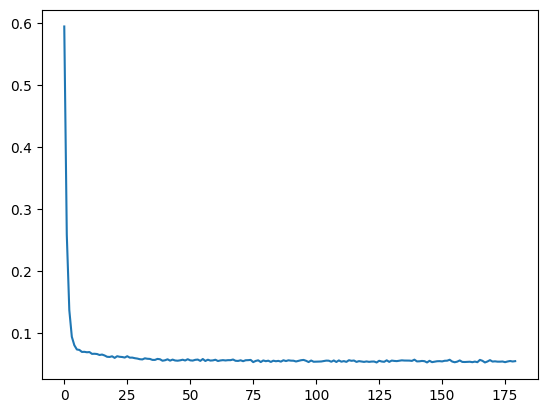

In [74]:
# batch mode converge at around 0.07 loss
# non- batch mode converge at around 0.91 loss (神奇..)

len(all_losses_list)
plt.figure()
plt.plot(all_losses_list)
plt.show()

##### Evaluation with RMSE

In [54]:
# None Batch mode 写法
# 这里直接拿 valid_dataset 来做 evaluation 了... 也就是不做 cross validation 了
from sklearn.metrics import mean_squared_error

model.eval() # 这个好像可有可无.?

model_output_list = []
target_rating_list = []

with torch.no_grad():
    for valid_data in valid_dataset:
        model_output = model(valid_data['users'], 
                       valid_data["movies"]).item()
        
        model_output_list.append(model_output)

        target_rating = valid_data["ratings"].item()
        
        target_rating_list.append(target_rating)

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")
# epoch=1 的 rmse 是 0.9534536636989602
# epoch=2 点 rmse 是 0.9477408281489875 那么其实没差多少..

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [75]:
# Batch Mode 写法: 用 dataloader 写法写一遍
# 这里直接拿 valid_dataset 来做 evaluation 了... 也就是不做 cross validation 了
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval() # 这个好像可有可无.?

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'], 
                       batched_data["movies"])
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")
# epoch=1 的 rmse 是  0.5247493256783067 (不过之前的non-dataloader 的写法写法是有问题的..)

model_output: tensor([[3.1872],
        [4.4746],
        [3.8946],
        [3.7848]]), target_rating: tensor([3, 5, 3, 5])
model_output: tensor([[3.5940],
        [4.0023],
        [3.5953],
        [3.3720]]), target_rating: tensor([2, 4, 1, 3])
model_output: tensor([[3.2052],
        [4.6486],
        [4.0097],
        [3.0149]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.3890],
        [3.5300],
        [3.0128],
        [4.5071]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.6518],
        [2.8810],
        [3.8013],
        [3.9088]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[4.5388],
        [3.6054],
        [3.7931],
        [4.1946]]), target_rating: tensor([2, 3, 3, 5])
model_output: tensor([[2.6400],
        [3.6280],
        [3.5310],
        [3.6019]]), target_rating: tensor([3, 5, 5, 5])
model_output: tensor([[3.4124],
        [2.3516],
        [3.5302],
        [2.0340]]), target_rating: tensor([4, 4, 3, 2])
model_ou

model_output: tensor([[4.3650],
        [3.4983],
        [3.8641],
        [3.2333]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[4.3498],
        [4.3736],
        [3.8801],
        [2.5887]]), target_rating: tensor([4, 5, 5, 2])
model_output: tensor([[3.9921],
        [3.8334],
        [3.5012],
        [2.7997]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[4.3250],
        [3.6446],
        [3.8977],
        [3.6494]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.9352],
        [2.9775],
        [4.1206],
        [2.8136]]), target_rating: tensor([5, 2, 3, 3])
model_output: tensor([[3.9567],
        [2.9575],
        [3.0319],
        [3.6579]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.5809],
        [4.3494],
        [3.2382],
        [3.4336]]), target_rating: tensor([4, 5, 2, 4])
model_output: tensor([[2.4974],
        [4.7791],
        [3.8164],
        [2.5533]]), target_rating: tensor([2, 5, 5, 3])
model_ou

model_output: tensor([[3.7055],
        [4.1677],
        [3.7787],
        [3.3791]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.6775],
        [3.5826],
        [3.4220],
        [3.5786]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[4.1768],
        [4.6248],
        [3.5154],
        [4.0894]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[4.4224],
        [3.6476],
        [3.6170],
        [3.4936]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.8931],
        [3.8885],
        [4.2310],
        [4.2646]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[4.0785],
        [3.5931],
        [4.3769],
        [3.0753]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[2.6371],
        [3.2564],
        [3.6607],
        [3.7092]]), target_rating: tensor([2, 3, 2, 4])
model_output: tensor([[2.9845],
        [1.1504],
        [3.8958],
        [2.2381]]), target_rating: tensor([2, 2, 5, 3])
model_ou

model_output: tensor([[3.7338],
        [4.7361],
        [2.4801],
        [3.5355]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.8859],
        [4.1894],
        [2.7553],
        [3.3279]]), target_rating: tensor([4, 4, 3, 1])
model_output: tensor([[4.7008],
        [2.9266],
        [4.1438],
        [2.7075]]), target_rating: tensor([2, 4, 3, 3])
model_output: tensor([[4.3314],
        [4.6130],
        [4.2331],
        [4.0440]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.2985],
        [4.4457],
        [2.0682],
        [3.2162]]), target_rating: tensor([3, 5, 2, 3])
model_output: tensor([[2.5633],
        [2.8336],
        [3.6431],
        [4.1927]]), target_rating: tensor([2, 5, 4, 5])
model_output: tensor([[2.6265],
        [3.7432],
        [3.3639],
        [2.9640]]), target_rating: tensor([3, 4, 2, 3])
model_output: tensor([[3.6628],
        [3.9550],
        [4.5729],
        [4.0523]]), target_rating: tensor([5, 5, 5, 5])
model_ou

model_output: tensor([[3.9769],
        [4.0481],
        [3.6848],
        [3.9122]]), target_rating: tensor([3, 5, 4, 5])
model_output: tensor([[3.5340],
        [4.5567],
        [3.7219],
        [4.7834]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[3.0451],
        [2.9242],
        [5.3627],
        [3.9355]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[3.8441],
        [3.9583],
        [3.3146],
        [3.4251]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.0505],
        [3.0016],
        [3.8304],
        [3.7767]]), target_rating: tensor([1, 5, 5, 4])
model_output: tensor([[2.9585],
        [3.3767],
        [3.3177],
        [2.7767]]), target_rating: tensor([4, 3, 4, 2])
model_output: tensor([[3.6398],
        [3.8275],
        [2.5621],
        [3.3961]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[3.6338],
        [3.2995],
        [2.7806],
        [3.0876]]), target_rating: tensor([4, 2, 3, 2])
model_ou

model_output: tensor([[3.3037],
        [1.4739],
        [1.2820],
        [3.9596]]), target_rating: tensor([1, 2, 2, 5])
model_output: tensor([[4.4479],
        [3.3252],
        [3.4599],
        [3.1574]]), target_rating: tensor([5, 4, 5, 1])
model_output: tensor([[4.4855],
        [3.0037],
        [2.7303],
        [2.8949]]), target_rating: tensor([4, 4, 3, 2])
model_output: tensor([[4.1649],
        [3.9720],
        [3.7719],
        [3.8580]]), target_rating: tensor([5, 2, 5, 4])
model_output: tensor([[4.2952],
        [3.8236],
        [2.5484],
        [2.8859]]), target_rating: tensor([3, 5, 4, 2])
model_output: tensor([[3.6839],
        [3.4702],
        [3.1357],
        [3.5278]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[4.2901],
        [2.8877],
        [2.9752],
        [4.1722]]), target_rating: tensor([5, 3, 3, 1])
model_output: tensor([[3.9326],
        [4.0585],
        [4.3386],
        [3.6203]]), target_rating: tensor([3, 4, 5, 4])
model_ou

model_output: tensor([[3.5752],
        [3.2447],
        [3.9206],
        [3.6470]]), target_rating: tensor([4, 1, 4, 4])
model_output: tensor([[3.8337],
        [3.7603],
        [2.8990],
        [4.0557]]), target_rating: tensor([3, 3, 4, 2])
model_output: tensor([[3.7385],
        [4.1798],
        [3.5728],
        [2.3501]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[2.9250],
        [2.7517],
        [3.9835],
        [4.0019]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[3.9763],
        [3.5118],
        [4.2270],
        [3.7806]]), target_rating: tensor([2, 4, 3, 4])
model_output: tensor([[3.0537],
        [2.0014],
        [4.4037],
        [2.8786]]), target_rating: tensor([2, 3, 5, 3])
model_output: tensor([[2.2883],
        [3.3260],
        [4.2676],
        [3.7080]]), target_rating: tensor([2, 3, 5, 5])
model_output: tensor([[3.5899],
        [4.8332],
        [3.9589],
        [3.7059]]), target_rating: tensor([5, 5, 5, 3])
model_ou

model_output: tensor([[3.7719],
        [3.6606],
        [2.7633],
        [4.5127]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.7294],
        [3.5097],
        [2.7553],
        [4.3389]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.8330],
        [2.9304],
        [2.5618],
        [3.4474]]), target_rating: tensor([5, 3, 3, 2])
model_output: tensor([[4.0011],
        [2.8852],
        [3.7173],
        [3.9494]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.5626],
        [3.3977],
        [4.3144],
        [2.7411]]), target_rating: tensor([3, 4, 4, 1])
model_output: tensor([[2.1533],
        [3.6068],
        [3.5863],
        [3.1358]]), target_rating: tensor([1, 4, 4, 2])
model_output: tensor([[4.4092],
        [3.9967],
        [3.7877],
        [4.0876]]), target_rating: tensor([4, 2, 5, 3])
model_output: tensor([[4.4589],
        [4.0312],
        [2.7911],
        [3.6825]]), target_rating: tensor([5, 3, 3, 4])
model_ou

model_output: tensor([[3.1266],
        [3.6389],
        [4.1701],
        [1.9420]]), target_rating: tensor([2, 4, 4, 2])
model_output: tensor([[4.2152],
        [3.9712],
        [4.1280],
        [2.5341]]), target_rating: tensor([5, 5, 4, 2])
model_output: tensor([[3.8208],
        [3.3615],
        [3.4222],
        [3.7346]]), target_rating: tensor([3, 5, 3, 5])
model_output: tensor([[4.1106],
        [2.4925],
        [3.3171],
        [4.1367]]), target_rating: tensor([5, 1, 2, 4])
model_output: tensor([[4.1642],
        [3.7791],
        [2.9502],
        [3.3649]]), target_rating: tensor([2, 5, 4, 4])
model_output: tensor([[4.0574],
        [3.8041],
        [3.2585],
        [3.6007]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.6458],
        [4.2482],
        [4.2111],
        [3.1747]]), target_rating: tensor([1, 4, 5, 3])
model_output: tensor([[2.5968],
        [4.0867],
        [3.7434],
        [3.3649]]), target_rating: tensor([2, 5, 4, 4])
model_ou

model_output: tensor([[4.1976],
        [4.8933],
        [3.4378],
        [4.4208]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[3.5600],
        [3.9532],
        [4.6123],
        [3.7129]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[3.7611],
        [4.5507],
        [2.8337],
        [3.6259]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[3.4013],
        [4.2648],
        [4.2982],
        [3.9336]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[4.2661],
        [4.0796],
        [4.1566],
        [1.7631]]), target_rating: tensor([4, 5, 4, 1])
model_output: tensor([[3.7082],
        [3.6104],
        [0.8196],
        [3.4125]]), target_rating: tensor([3, 4, 1, 5])
model_output: tensor([[4.2136],
        [4.1433],
        [3.4423],
        [4.2799]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[4.0850],
        [4.2981],
        [3.2807],
        [1.8832]]), target_rating: tensor([4, 3, 5, 4])
model_ou

model_output: tensor([[4.0026],
        [3.7541],
        [3.4117],
        [3.1736]]), target_rating: tensor([5, 3, 5, 3])
model_output: tensor([[3.6448],
        [2.6793],
        [2.3821],
        [4.1800]]), target_rating: tensor([4, 2, 2, 4])
model_output: tensor([[2.2170],
        [3.9311],
        [2.8200],
        [3.3447]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[3.9915],
        [3.2995],
        [3.5893],
        [4.1628]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.9482],
        [4.1951],
        [4.0832],
        [2.8625]]), target_rating: tensor([5, 5, 4, 4])
model_output: tensor([[3.4537],
        [3.1954],
        [3.4969],
        [4.7565]]), target_rating: tensor([3, 4, 2, 4])
model_output: tensor([[4.2854],
        [3.7546],
        [3.8681],
        [2.8296]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[1.9040],
        [4.3614],
        [3.5274],
        [3.8393]]), target_rating: tensor([2, 5, 4, 5])
model_ou

model_output: tensor([[3.5676],
        [3.6342],
        [2.9836],
        [3.1533]]), target_rating: tensor([5, 2, 4, 1])
model_output: tensor([[3.6953],
        [2.9327],
        [4.1816],
        [3.1044]]), target_rating: tensor([4, 3, 5, 1])
model_output: tensor([[4.0875],
        [3.1078],
        [2.4195],
        [2.8716]]), target_rating: tensor([4, 2, 2, 3])
model_output: tensor([[4.5646],
        [2.3128],
        [3.4979],
        [3.9227]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[3.9328],
        [3.9457],
        [3.1838],
        [4.0497]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.2667],
        [3.2619],
        [3.4714],
        [3.4388]]), target_rating: tensor([2, 2, 4, 4])
model_output: tensor([[3.8169],
        [3.6794],
        [3.5175],
        [4.4147]]), target_rating: tensor([5, 5, 2, 4])
model_output: tensor([[3.4686],
        [3.8734],
        [3.1301],
        [4.2784]]), target_rating: tensor([4, 5, 2, 4])
model_ou

model_output: tensor([[3.3179],
        [3.5690],
        [4.5099],
        [3.0228]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[2.5263],
        [4.1565],
        [3.8715],
        [2.8561]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[4.0646],
        [2.4729],
        [3.6747],
        [3.4798]]), target_rating: tensor([4, 1, 4, 2])
model_output: tensor([[4.0806],
        [3.9169],
        [1.9150],
        [4.2632]]), target_rating: tensor([5, 4, 2, 4])
model_output: tensor([[2.6305],
        [3.5001],
        [3.7949],
        [4.1696]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[2.4238],
        [2.2314],
        [2.3183],
        [4.2674]]), target_rating: tensor([2, 2, 2, 5])
model_output: tensor([[4.1118],
        [3.8760],
        [3.1840],
        [3.5525]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[4.7393],
        [3.4250],
        [2.4553],
        [3.6604]]), target_rating: tensor([5, 5, 3, 5])
model_ou

model_output: tensor([[4.0986],
        [3.5598],
        [4.2799],
        [3.9362]]), target_rating: tensor([5, 3, 5, 5])
model_output: tensor([[3.3290],
        [3.5537],
        [3.4285],
        [4.2805]]), target_rating: tensor([2, 3, 4, 5])
model_output: tensor([[3.5676],
        [2.9261],
        [2.4532],
        [4.2134]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[4.3218],
        [3.1762],
        [3.3838],
        [4.0555]]), target_rating: tensor([5, 3, 5, 4])
model_output: tensor([[3.5254],
        [3.8737],
        [3.7710],
        [3.3702]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[3.8691],
        [3.3296],
        [4.8982],
        [3.6068]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[4.2460],
        [3.4927],
        [3.2698],
        [3.3571]]), target_rating: tensor([5, 4, 2, 5])
model_output: tensor([[3.2896],
        [2.2660],
        [2.7538],
        [4.0640]]), target_rating: tensor([5, 1, 2, 4])
model_ou

model_output: tensor([[3.4746],
        [4.0610],
        [3.8267],
        [3.7264]]), target_rating: tensor([3, 5, 4, 3])
model_output: tensor([[2.9880],
        [2.8166],
        [1.9466],
        [3.1400]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[2.8464],
        [3.2635],
        [4.2486],
        [3.5520]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.7935],
        [4.7767],
        [4.3365],
        [3.3899]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.3418],
        [2.2928],
        [4.2582],
        [3.9266]]), target_rating: tensor([4, 2, 5, 4])
model_output: tensor([[2.9610],
        [4.1207],
        [3.5590],
        [3.6940]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.6322],
        [4.1002],
        [4.0038],
        [4.1443]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.4266],
        [4.0451],
        [3.3047],
        [2.1370]]), target_rating: tensor([5, 5, 5, 5])
model_ou

model_output: tensor([[3.9522],
        [4.3963],
        [3.7581],
        [3.5559]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[3.5106],
        [4.4472],
        [4.3344],
        [4.0278]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[2.5034],
        [4.4173],
        [4.0916],
        [3.1849]]), target_rating: tensor([2, 5, 4, 2])
model_output: tensor([[3.4408],
        [3.8735],
        [4.6894],
        [3.7196]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.9434],
        [4.2389],
        [4.5807],
        [3.9087]]), target_rating: tensor([3, 4, 4, 5])
model_output: tensor([[3.3694],
        [2.4698],
        [4.6034],
        [3.6234]]), target_rating: tensor([3, 1, 4, 3])
model_output: tensor([[3.6804],
        [2.7966],
        [3.5129],
        [4.0790]]), target_rating: tensor([4, 2, 2, 5])
model_output: tensor([[3.3157],
        [2.8642],
        [3.6837],
        [2.8831]]), target_rating: tensor([5, 1, 5, 3])
model_ou

model_output: tensor([[4.0357],
        [2.4258],
        [4.5571],
        [3.8432]]), target_rating: tensor([4, 1, 5, 4])
model_output: tensor([[4.1081],
        [3.8378],
        [2.9531],
        [3.4014]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[3.3461],
        [2.8052],
        [4.6617],
        [3.0528]]), target_rating: tensor([4, 3, 5, 2])
model_output: tensor([[3.9062],
        [3.9775],
        [3.4874],
        [4.7649]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.6418],
        [4.0273],
        [3.6726],
        [4.1210]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[2.3652],
        [3.7174],
        [4.2600],
        [3.0737]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.7349],
        [4.2439],
        [2.4402],
        [3.6442]]), target_rating: tensor([2, 5, 3, 4])
model_output: tensor([[4.1953],
        [4.5007],
        [1.9367],
        [3.1967]]), target_rating: tensor([3, 4, 4, 2])
model_ou

model_output: tensor([[3.4079],
        [3.6774],
        [3.9989],
        [3.8309]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[4.1805],
        [4.0061],
        [4.3250],
        [3.5779]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[4.1148],
        [3.0361],
        [4.1303],
        [3.1009]]), target_rating: tensor([4, 2, 4, 3])
model_output: tensor([[4.3549],
        [3.6298],
        [4.7948],
        [4.7562]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[2.6692],
        [3.3505],
        [3.6791],
        [3.4817]]), target_rating: tensor([1, 3, 3, 4])
model_output: tensor([[3.7350],
        [3.4862],
        [4.0143],
        [3.9033]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.4062],
        [4.3538],
        [3.9475],
        [3.9753]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[4.2949],
        [3.3805],
        [4.3381],
        [2.7510]]), target_rating: tensor([4, 5, 5, 2])
model_ou

model_output: tensor([[4.1603],
        [3.0298],
        [3.4597],
        [3.0757]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[3.6902],
        [2.5402],
        [3.7813],
        [3.6587]]), target_rating: tensor([4, 2, 2, 5])
model_output: tensor([[3.5763],
        [4.4414],
        [2.7397],
        [2.8788]]), target_rating: tensor([4, 4, 2, 2])
model_output: tensor([[3.7398],
        [4.3704],
        [3.1352],
        [3.4736]]), target_rating: tensor([4, 5, 1, 5])
model_output: tensor([[3.8861],
        [3.7371],
        [3.8651],
        [3.9053]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[3.2710],
        [2.6531],
        [3.3599],
        [2.7753]]), target_rating: tensor([3, 4, 3, 1])
model_output: tensor([[3.1603],
        [3.5126],
        [3.6202],
        [3.2890]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[3.4271],
        [3.5873],
        [3.2410],
        [3.9181]]), target_rating: tensor([3, 3, 4, 3])
model_ou

model_output: tensor([[3.4015],
        [3.2236],
        [2.3568],
        [1.5708]]), target_rating: tensor([5, 2, 1, 2])
model_output: tensor([[2.4139],
        [3.3114],
        [3.0952],
        [3.8536]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.1503],
        [3.5497],
        [2.8836],
        [3.6452]]), target_rating: tensor([2, 3, 2, 4])
model_output: tensor([[4.5512],
        [3.2244],
        [3.6708],
        [3.5259]]), target_rating: tensor([5, 3, 3, 4])
model_output: tensor([[3.5869],
        [3.4680],
        [4.4846],
        [4.6821]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[3.6743],
        [3.8757],
        [2.7402],
        [4.2277]]), target_rating: tensor([3, 4, 1, 4])
model_output: tensor([[3.9215],
        [3.5484],
        [3.5504],
        [2.4551]]), target_rating: tensor([5, 4, 5, 2])
model_output: tensor([[4.3901],
        [4.1912],
        [3.3468],
        [3.2349]]), target_rating: tensor([4, 5, 3, 5])
model_ou

model_output: tensor([[4.1377],
        [4.0139],
        [4.3667],
        [2.0969]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[4.0191],
        [3.0277],
        [3.8206],
        [1.9953]]), target_rating: tensor([5, 1, 4, 1])
model_output: tensor([[1.9316],
        [2.9819],
        [4.1088],
        [5.2328]]), target_rating: tensor([1, 5, 5, 5])
model_output: tensor([[4.3482],
        [4.1466],
        [3.9737],
        [3.5412]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[3.7613],
        [3.6972],
        [3.8732],
        [4.7123]]), target_rating: tensor([3, 3, 5, 5])
model_output: tensor([[3.7884],
        [3.5960],
        [3.8934],
        [2.5770]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[3.4305],
        [4.1349],
        [4.2232],
        [2.9716]]), target_rating: tensor([5, 5, 5, 2])
model_output: tensor([[3.8181],
        [3.4011],
        [2.8995],
        [3.5313]]), target_rating: tensor([3, 1, 2, 4])
model_ou

model_output: tensor([[3.6076],
        [4.3775],
        [3.7679],
        [3.1348]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[1.7740],
        [3.7885],
        [3.5887],
        [3.0520]]), target_rating: tensor([2, 3, 4, 3])
model_output: tensor([[3.0978],
        [3.5305],
        [3.9253],
        [4.4763]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[3.5919],
        [3.4978],
        [4.5906],
        [3.1981]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[3.9573],
        [3.7614],
        [4.6250],
        [4.0928]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[2.9080],
        [4.3163],
        [3.7270],
        [3.2057]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.3706],
        [5.1851],
        [3.3801],
        [3.4015]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.5991],
        [1.8396],
        [4.0591],
        [2.8404]]), target_rating: tensor([5, 3, 4, 5])
model_ou

model_output: tensor([[5.3080],
        [4.0326],
        [3.1125],
        [4.1551]]), target_rating: tensor([3, 5, 5, 5])
model_output: tensor([[3.8929],
        [4.5498],
        [3.5666],
        [3.5022]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[1.5995],
        [3.9740],
        [3.2855],
        [4.3552]]), target_rating: tensor([1, 4, 5, 3])
model_output: tensor([[3.7502],
        [3.6518],
        [3.7370],
        [3.5814]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[4.1055],
        [3.7471],
        [3.2878],
        [3.3061]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[4.5231],
        [3.8297],
        [3.9276],
        [3.9705]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.8022],
        [3.6266],
        [4.2289],
        [2.6225]]), target_rating: tensor([2, 4, 5, 2])
model_output: tensor([[4.5653],
        [3.0969],
        [4.4670],
        [3.6730]]), target_rating: tensor([5, 3, 5, 2])
model_ou

model_output: tensor([[2.7821],
        [4.3127],
        [3.8898],
        [3.1051]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[4.0562],
        [2.5242],
        [3.8796],
        [3.6430]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[4.1080],
        [4.1743],
        [3.9808],
        [3.2259]]), target_rating: tensor([4, 5, 5, 5])
model_output: tensor([[3.4881],
        [3.6615],
        [3.1885],
        [3.7593]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[4.6352],
        [4.0048],
        [3.7843],
        [4.0907]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[4.0258],
        [1.8566],
        [4.1835],
        [3.1053]]), target_rating: tensor([4, 1, 4, 3])
model_output: tensor([[2.8482],
        [3.3957],
        [4.3121],
        [2.1538]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.3396],
        [3.8701],
        [4.1405],
        [3.5237]]), target_rating: tensor([3, 5, 2, 1])
model_ou

model_output: tensor([[4.0754],
        [3.5656],
        [3.9313],
        [3.1720]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.5116],
        [4.3649],
        [4.4341],
        [4.2912]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[4.1797],
        [3.3621],
        [2.8409],
        [3.4531]]), target_rating: tensor([5, 2, 2, 4])
model_output: tensor([[3.8158],
        [4.3120],
        [3.4548],
        [2.8758]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.1972],
        [2.9706],
        [3.5384],
        [3.3764]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[4.1438],
        [3.0773],
        [2.3650],
        [3.6856]]), target_rating: tensor([3, 4, 1, 4])
model_output: tensor([[3.0407],
        [3.0337],
        [3.9221],
        [2.7580]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[4.7460],
        [3.3468],
        [4.0667],
        [3.2847]]), target_rating: tensor([5, 4, 5, 4])
model_ou

model_output: tensor([[4.5051],
        [3.6017],
        [2.4421],
        [4.2257]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[2.4700],
        [3.6841],
        [3.6113],
        [3.3854]]), target_rating: tensor([1, 5, 2, 5])
model_output: tensor([[3.0584],
        [3.6729],
        [3.5266],
        [3.3785]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[2.9459],
        [3.7326],
        [3.0033],
        [4.0544]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[4.3956],
        [4.2764],
        [2.9648],
        [3.1326]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.8505],
        [3.4246],
        [3.9185],
        [2.1491]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.5421],
        [3.1984],
        [3.9588],
        [4.3497]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[4.0233],
        [4.2727],
        [3.7074],
        [3.4754]]), target_rating: tensor([3, 3, 4, 5])
model_ou

model_output: tensor([[2.4848],
        [2.7490],
        [3.1878],
        [2.5180]]), target_rating: tensor([1, 3, 3, 1])
model_output: tensor([[3.8017],
        [4.6108],
        [2.9947],
        [4.4689]]), target_rating: tensor([2, 4, 2, 5])
model_output: tensor([[4.5433],
        [3.7698],
        [3.7709],
        [3.3976]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[3.7876],
        [3.2598],
        [4.5598],
        [3.5408]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.5834],
        [4.7801],
        [3.3426],
        [3.3189]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[1.4776],
        [4.8318],
        [1.5871],
        [3.9235]]), target_rating: tensor([1, 5, 1, 4])
model_output: tensor([[2.9258],
        [3.7056],
        [3.2013],
        [3.8328]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[3.9696],
        [2.8605],
        [4.2389],
        [4.2823]]), target_rating: tensor([3, 4, 5, 5])
model_ou

model_output: tensor([[3.4337],
        [4.2000],
        [4.0597],
        [3.8893]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[2.9785],
        [3.9354],
        [3.5396],
        [3.2764]]), target_rating: tensor([1, 5, 3, 4])
model_output: tensor([[4.3685],
        [3.2752],
        [3.9694],
        [3.4345]]), target_rating: tensor([5, 4, 4, 1])
model_output: tensor([[3.3068],
        [3.0990],
        [3.5643],
        [4.7261]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[2.7217],
        [3.9635],
        [4.3155],
        [4.7382]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[4.2214],
        [4.1337],
        [4.7891],
        [3.7410]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[4.3545],
        [4.9654],
        [3.5739],
        [2.8736]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.6100],
        [3.5364],
        [3.2110],
        [3.0223]]), target_rating: tensor([4, 5, 2, 3])
model_ou

model_output: tensor([[3.7216],
        [2.8505],
        [3.8104],
        [3.7707]]), target_rating: tensor([5, 3, 5, 4])
model_output: tensor([[4.4244],
        [5.0629],
        [4.0728],
        [4.0788]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[2.9740],
        [3.3394],
        [4.0119],
        [3.3951]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[2.8366],
        [2.7024],
        [3.3979],
        [2.2683]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[4.2810],
        [4.0517],
        [2.6763],
        [3.5061]]), target_rating: tensor([3, 3, 3, 1])
model_output: tensor([[4.2738],
        [4.2736],
        [2.4725],
        [3.6684]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[2.4588],
        [4.0214],
        [3.7673],
        [3.1003]]), target_rating: tensor([2, 5, 1, 4])
model_output: tensor([[3.8145],
        [3.5741],
        [3.1475],
        [2.3928]]), target_rating: tensor([4, 4, 4, 2])
model_ou

model_output: tensor([[3.1256],
        [2.1862],
        [5.3327],
        [3.1613]]), target_rating: tensor([4, 2, 5, 4])
model_output: tensor([[3.9294],
        [4.2572],
        [4.2077],
        [3.3822]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[3.8829],
        [4.7020],
        [3.0164],
        [3.9330]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[2.9003],
        [3.4569],
        [2.3318],
        [4.0975]]), target_rating: tensor([1, 4, 3, 4])
model_output: tensor([[4.2320],
        [3.9641],
        [3.3621],
        [2.3334]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[3.6618],
        [2.8548],
        [4.2446],
        [4.1551]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[2.3138],
        [3.0145],
        [2.9228],
        [3.4758]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[3.7497],
        [3.6668],
        [2.5359],
        [4.6058]]), target_rating: tensor([4, 4, 3, 5])
model_ou

model_output: tensor([[2.8398],
        [2.5377],
        [4.8383],
        [3.9019]]), target_rating: tensor([3, 1, 4, 4])
model_output: tensor([[2.4541],
        [3.8282],
        [4.8333],
        [4.2872]]), target_rating: tensor([4, 1, 5, 4])
model_output: tensor([[4.7484],
        [3.4185],
        [3.9093],
        [4.6471]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[4.0845],
        [3.6843],
        [4.3474],
        [3.5428]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[3.4085],
        [3.7953],
        [3.8093],
        [4.1958]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[2.5496],
        [4.2069],
        [4.5507],
        [3.8834]]), target_rating: tensor([2, 4, 5, 4])
model_output: tensor([[3.9594],
        [3.9273],
        [3.4727],
        [1.7646]]), target_rating: tensor([3, 1, 3, 1])
model_output: tensor([[3.7078],
        [2.7982],
        [2.3166],
        [3.0899]]), target_rating: tensor([4, 4, 1, 5])
model_ou

model_output: tensor([[3.1741],
        [3.8995],
        [3.6264],
        [2.1358]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[3.6840],
        [4.1304],
        [3.3932],
        [3.3370]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[2.7407],
        [4.3514],
        [2.8230],
        [3.7370]]), target_rating: tensor([2, 4, 3, 4])
model_output: tensor([[3.5941],
        [3.8158],
        [3.2358],
        [4.4792]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[3.3703],
        [2.9109],
        [3.5307],
        [3.8791]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[5.0956],
        [4.2798],
        [3.6376],
        [3.5897]]), target_rating: tensor([5, 4, 5, 2])
model_output: tensor([[3.0304],
        [4.8911],
        [4.7477],
        [4.0426]]), target_rating: tensor([4, 3, 3, 2])
model_output: tensor([[3.8474],
        [3.5575],
        [3.4939],
        [3.8677]]), target_rating: tensor([4, 4, 5, 4])
model_ou

model_output: tensor([[4.3293],
        [4.6359],
        [4.1636],
        [4.1753]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[3.2213],
        [4.2677],
        [4.0340],
        [3.2252]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[2.6050],
        [3.7527],
        [3.5958],
        [3.6472]]), target_rating: tensor([2, 4, 4, 5])
model_output: tensor([[3.6275],
        [4.1550],
        [3.6965],
        [3.3380]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[3.6556],
        [3.0742],
        [3.5048],
        [4.0473]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.7355],
        [3.1381],
        [4.0903],
        [3.4755]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.1476],
        [3.5888],
        [4.8996],
        [4.4235]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.3624],
        [2.7160],
        [3.9765],
        [2.8077]]), target_rating: tensor([4, 3, 3, 5])
model_ou

model_output: tensor([[3.1648],
        [3.6463],
        [3.0546],
        [4.1741]]), target_rating: tensor([2, 4, 3, 4])
model_output: tensor([[3.7313],
        [2.7317],
        [4.1448],
        [3.6355]]), target_rating: tensor([4, 1, 4, 4])
model_output: tensor([[3.5982],
        [3.7186],
        [2.5645],
        [3.7043]]), target_rating: tensor([3, 1, 2, 5])
model_output: tensor([[4.4528],
        [2.6687],
        [4.3581],
        [4.2486]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[2.4805],
        [3.9096],
        [4.3637],
        [3.1394]]), target_rating: tensor([2, 3, 4, 4])
model_output: tensor([[3.5556],
        [4.3507],
        [3.6799],
        [3.3713]]), target_rating: tensor([2, 4, 2, 4])
model_output: tensor([[3.1983],
        [3.9271],
        [3.9430],
        [2.1911]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.1537],
        [2.4872],
        [1.8935],
        [3.9119]]), target_rating: tensor([3, 4, 2, 5])
model_ou

model_output: tensor([[3.2931],
        [3.7356],
        [3.5253],
        [3.4792]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[4.4542],
        [3.9819],
        [4.3421],
        [1.4981]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[2.9101],
        [4.4191],
        [3.3212],
        [3.1981]]), target_rating: tensor([1, 4, 3, 5])
model_output: tensor([[2.8950],
        [4.3595],
        [3.3413],
        [3.9046]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[4.4519],
        [4.1328],
        [3.0484],
        [2.5184]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.8803],
        [2.9513],
        [3.1053],
        [2.1472]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.6713],
        [2.9485],
        [4.3817],
        [3.7722]]), target_rating: tensor([5, 4, 5, 5])
model_output: tensor([[1.6070],
        [3.3457],
        [4.6676],
        [2.8779]]), target_rating: tensor([1, 3, 4, 3])
model_ou

model_output: tensor([[4.2050],
        [4.1914],
        [4.2114],
        [2.9645]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[2.6789],
        [3.2418],
        [3.6549],
        [3.0333]]), target_rating: tensor([2, 3, 2, 2])
model_output: tensor([[3.4442],
        [2.5248],
        [2.5853],
        [3.2709]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.5687],
        [4.5278],
        [3.9479],
        [3.8831]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[4.9111],
        [4.1486],
        [2.0237],
        [1.4376]]), target_rating: tensor([3, 4, 1, 1])
model_output: tensor([[3.8892],
        [3.8819],
        [3.9788],
        [3.4309]]), target_rating: tensor([5, 3, 5, 4])
model_output: tensor([[3.7918],
        [3.9789],
        [3.5446],
        [3.7756]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[2.6338],
        [3.6149],
        [4.0892],
        [2.9495]]), target_rating: tensor([3, 4, 3, 3])
model_ou

model_output: tensor([[4.1868],
        [2.3132],
        [4.2120],
        [3.2111]]), target_rating: tensor([4, 5, 5, 4])
model_output: tensor([[3.2632],
        [2.9485],
        [2.5018],
        [4.4164]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[3.2485],
        [4.3379],
        [4.1009],
        [4.3011]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.5417],
        [3.4396],
        [3.8406],
        [4.3069]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.6901],
        [2.8059],
        [2.7132],
        [2.7548]]), target_rating: tensor([5, 2, 3, 1])
model_output: tensor([[3.4408],
        [3.5251],
        [2.2772],
        [3.4212]]), target_rating: tensor([4, 3, 2, 3])
model_output: tensor([[3.3022],
        [4.4610],
        [3.6391],
        [3.8408]]), target_rating: tensor([3, 5, 4, 5])
model_output: tensor([[2.8140],
        [3.8999],
        [3.6415],
        [2.8331]]), target_rating: tensor([2, 4, 5, 1])
model_ou

model_output: tensor([[3.0507],
        [4.5495],
        [2.7828],
        [4.0777]]), target_rating: tensor([1, 5, 3, 4])
model_output: tensor([[1.3277],
        [4.5370],
        [3.8245],
        [4.2570]]), target_rating: tensor([1, 5, 4, 4])
model_output: tensor([[4.3238],
        [4.0756],
        [4.0055],
        [3.3738]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.3153],
        [3.3745],
        [4.3920],
        [3.9562]]), target_rating: tensor([5, 3, 5, 5])
model_output: tensor([[3.7696],
        [4.5363],
        [3.1282],
        [2.6395]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[3.8730],
        [3.3977],
        [3.2326],
        [3.3284]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[3.5994],
        [4.4216],
        [2.4584],
        [4.1431]]), target_rating: tensor([4, 5, 2, 5])
model_output: tensor([[3.2731],
        [3.3631],
        [4.3438],
        [2.8154]]), target_rating: tensor([4, 2, 4, 3])
model_ou

model_output: tensor([[3.4793],
        [4.1270],
        [3.6252],
        [3.6006]]), target_rating: tensor([5, 4, 1, 2])
model_output: tensor([[4.3425],
        [2.9512],
        [4.1059],
        [4.0573]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[2.8058],
        [3.8013],
        [3.2628],
        [4.2500]]), target_rating: tensor([2, 5, 4, 4])
model_output: tensor([[3.9495],
        [4.1544],
        [3.8615],
        [2.9110]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[4.2904],
        [2.9000],
        [4.5884],
        [2.9513]]), target_rating: tensor([5, 3, 3, 2])
model_output: tensor([[1.5791],
        [3.6321],
        [3.4348],
        [3.9562]]), target_rating: tensor([2, 4, 5, 1])
model_output: tensor([[3.9633],
        [3.0438],
        [3.0605],
        [3.9482]]), target_rating: tensor([2, 3, 4, 3])
model_output: tensor([[3.7938],
        [3.9631],
        [3.1352],
        [3.1563]]), target_rating: tensor([3, 4, 3, 3])
model_ou

model_output: tensor([[3.4023],
        [3.9006],
        [3.5294],
        [3.7104]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[2.8844],
        [3.4457],
        [3.0879],
        [3.5549]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[3.7621],
        [3.0723],
        [3.2781],
        [4.0769]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.4896],
        [3.2086],
        [3.7546],
        [5.4177]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.8083],
        [2.9283],
        [3.3502],
        [3.3009]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.2921],
        [3.5120],
        [2.8076],
        [1.9462]]), target_rating: tensor([4, 2, 4, 1])
model_output: tensor([[4.3388],
        [2.8633],
        [3.2888],
        [3.0115]]), target_rating: tensor([4, 4, 3, 1])
model_output: tensor([[3.2454],
        [2.2351],
        [3.0170],
        [2.4623]]), target_rating: tensor([4, 1, 3, 1])
model_ou

model_output: tensor([[3.3208],
        [3.6375],
        [3.6901],
        [4.2133]]), target_rating: tensor([3, 2, 4, 2])
model_output: tensor([[4.1954],
        [3.9139],
        [3.8059],
        [3.8148]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[2.3212],
        [3.7715],
        [3.1318],
        [4.8984]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[3.6739],
        [3.6288],
        [3.5771],
        [3.9820]]), target_rating: tensor([4, 5, 5, 4])
model_output: tensor([[3.9729],
        [4.1016],
        [3.5586],
        [1.5625]]), target_rating: tensor([4, 3, 3, 1])
model_output: tensor([[3.3948],
        [3.3968],
        [5.3053],
        [3.0609]]), target_rating: tensor([5, 3, 5, 2])
model_output: tensor([[4.0949],
        [4.9828],
        [4.5271],
        [3.4415]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[4.0134],
        [3.5498],
        [3.1719],
        [3.0474]]), target_rating: tensor([5, 4, 4, 4])
model_ou

model_output: tensor([[2.2569],
        [4.0760],
        [4.4117],
        [3.6992]]), target_rating: tensor([1, 5, 4, 3])
model_output: tensor([[4.0412],
        [3.3227],
        [4.1995],
        [4.4146]]), target_rating: tensor([4, 1, 4, 5])
model_output: tensor([[4.7280],
        [4.3735],
        [4.3873],
        [3.1745]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[3.1662],
        [4.0834],
        [2.8014],
        [3.9025]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.8008],
        [3.0708],
        [3.2271],
        [3.5251]]), target_rating: tensor([4, 3, 3, 3])
model_output: tensor([[5.0676],
        [3.2428],
        [2.4274],
        [2.9280]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[2.8397],
        [2.8202],
        [3.0914],
        [4.6096]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[4.1582],
        [3.0221],
        [3.9085],
        [3.6033]]), target_rating: tensor([4, 4, 4, 4])
model_ou

model_output: tensor([[3.4238],
        [3.8226],
        [3.2198],
        [2.6314]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[2.6356],
        [4.2233],
        [3.5341],
        [3.6080]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[4.5047],
        [3.1035],
        [2.0930],
        [2.3070]]), target_rating: tensor([5, 5, 1, 3])
model_output: tensor([[3.5798],
        [4.5196],
        [2.6290],
        [3.7469]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[3.5848],
        [3.2373],
        [4.1194],
        [4.1335]]), target_rating: tensor([5, 3, 2, 3])
model_output: tensor([[2.2543],
        [3.2873],
        [3.0895],
        [3.7198]]), target_rating: tensor([3, 1, 3, 4])
model_output: tensor([[3.4221],
        [3.2755],
        [3.9514],
        [3.7530]]), target_rating: tensor([5, 4, 2, 3])
model_output: tensor([[3.9574],
        [3.5269],
        [4.0792],
        [3.4365]]), target_rating: tensor([4, 3, 5, 5])
model_ou

model_output: tensor([[3.2102],
        [3.9179],
        [3.6715],
        [4.2583]]), target_rating: tensor([3, 5, 2, 5])
model_output: tensor([[3.9572],
        [4.0190],
        [2.7589],
        [3.9636]]), target_rating: tensor([5, 4, 2, 4])
model_output: tensor([[3.9943],
        [4.2448],
        [4.3320],
        [3.8739]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[2.9088],
        [3.7881],
        [3.7246],
        [4.0803]]), target_rating: tensor([2, 1, 4, 4])
model_output: tensor([[3.3429],
        [4.4215],
        [3.3006],
        [4.1342]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[2.4693],
        [3.9696],
        [4.1126],
        [3.6850]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[4.0217],
        [2.9502],
        [3.0737],
        [3.5972]]), target_rating: tensor([5, 4, 2, 4])
model_output: tensor([[5.3066],
        [4.0517],
        [4.1840],
        [3.4421]]), target_rating: tensor([5, 5, 2, 3])
model_ou

model_output: tensor([[2.9781],
        [2.9278],
        [3.4723],
        [4.0966]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.2328],
        [3.5432],
        [2.9943],
        [2.9207]]), target_rating: tensor([2, 4, 3, 4])
model_output: tensor([[3.5049],
        [4.0604],
        [3.5917],
        [2.5702]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.5803],
        [3.5799],
        [3.9017],
        [4.5008]]), target_rating: tensor([3, 4, 2, 4])
model_output: tensor([[3.3759],
        [3.6505],
        [2.9681],
        [4.4359]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.5232],
        [2.1512],
        [3.3904],
        [3.0403]]), target_rating: tensor([3, 1, 4, 4])
model_output: tensor([[3.9959],
        [4.0064],
        [1.8222],
        [3.6555]]), target_rating: tensor([4, 5, 1, 4])
model_output: tensor([[3.1640],
        [3.5545],
        [2.6381],
        [3.8006]]), target_rating: tensor([4, 2, 2, 3])
model_ou

model_output: tensor([[3.7684],
        [3.0703],
        [3.3413],
        [3.6123]]), target_rating: tensor([3, 2, 3, 3])
model_output: tensor([[3.2141],
        [3.8704],
        [3.5366],
        [4.6297]]), target_rating: tensor([3, 1, 3, 5])
model_output: tensor([[3.4955],
        [3.5580],
        [3.4716],
        [4.1731]]), target_rating: tensor([4, 5, 1, 5])
model_output: tensor([[4.2784],
        [3.8344],
        [3.9059],
        [4.0237]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[2.4155],
        [3.3970],
        [4.5928],
        [3.3022]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.2627],
        [5.2908],
        [2.9860],
        [3.2144]]), target_rating: tensor([2, 5, 3, 2])
model_output: tensor([[3.6091],
        [3.2020],
        [4.1164],
        [3.7690]]), target_rating: tensor([4, 2, 5, 3])
model_output: tensor([[4.4025],
        [3.7396],
        [3.7517],
        [2.8661]]), target_rating: tensor([5, 5, 5, 4])
model_ou

model_output: tensor([[4.1243],
        [2.4285],
        [3.9989],
        [3.3545]]), target_rating: tensor([3, 1, 5, 4])
model_output: tensor([[2.7865],
        [4.0001],
        [3.8952],
        [2.6868]]), target_rating: tensor([3, 3, 4, 2])
model_output: tensor([[3.6407],
        [3.6258],
        [4.3900],
        [4.2907]]), target_rating: tensor([4, 2, 5, 5])
model_output: tensor([[2.1754],
        [3.7039],
        [4.1221],
        [3.5714]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[3.6764],
        [3.8738],
        [4.0954],
        [3.9800]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[4.1133],
        [2.3378],
        [3.4203],
        [4.1155]]), target_rating: tensor([5, 1, 5, 5])
model_output: tensor([[3.4444],
        [4.5423],
        [3.4010],
        [3.1167]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[3.0918],
        [3.8916],
        [4.1388],
        [3.9059]]), target_rating: tensor([2, 4, 2, 3])
model_ou

model_output: tensor([[3.4920],
        [3.4211],
        [4.4989],
        [3.2559]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.3487],
        [4.0436],
        [3.8269],
        [3.1564]]), target_rating: tensor([5, 3, 3, 4])
model_output: tensor([[3.2252],
        [3.0111],
        [2.6600],
        [3.4814]]), target_rating: tensor([5, 4, 2, 3])
model_output: tensor([[1.7936],
        [3.3714],
        [2.8608],
        [3.2214]]), target_rating: tensor([1, 4, 2, 4])
model_output: tensor([[3.4779],
        [3.5165],
        [4.2773],
        [4.3684]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[5.1322],
        [3.1918],
        [3.5134],
        [4.2894]]), target_rating: tensor([5, 3, 5, 5])
model_output: tensor([[3.0134],
        [4.3548],
        [2.7519],
        [2.6740]]), target_rating: tensor([2, 4, 2, 2])
model_output: tensor([[5.0297],
        [3.0253],
        [4.2750],
        [5.0996]]), target_rating: tensor([5, 4, 4, 2])
model_ou

model_output: tensor([[2.8089],
        [4.0042],
        [2.8896],
        [3.7235]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[2.8101],
        [3.9896],
        [4.8650],
        [3.8496]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[2.2903],
        [3.0448],
        [4.1955],
        [4.3486]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[2.3463],
        [3.3265],
        [3.5383],
        [4.2226]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.8733],
        [3.4692],
        [3.7511],
        [3.1073]]), target_rating: tensor([3, 1, 1, 3])
model_output: tensor([[2.6111],
        [3.5655],
        [3.4688],
        [2.6572]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[3.8588],
        [3.8477],
        [4.1591],
        [4.2512]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.3969],
        [4.2165],
        [3.1420],
        [3.9155]]), target_rating: tensor([5, 4, 3, 4])
model_ou

model_output: tensor([[2.7045],
        [2.9371],
        [4.0802],
        [3.3750]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[3.3654],
        [4.5141],
        [3.7396],
        [4.2275]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[4.4897],
        [3.3332],
        [3.3130],
        [4.8164]]), target_rating: tensor([4, 2, 3, 5])
model_output: tensor([[4.3133],
        [3.9197],
        [3.1048],
        [3.5347]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.0250],
        [3.6112],
        [2.8945],
        [3.4211]]), target_rating: tensor([3, 2, 3, 2])
model_output: tensor([[3.7203],
        [2.8838],
        [4.1078],
        [3.8172]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.7656],
        [3.6599],
        [3.7891],
        [3.8701]]), target_rating: tensor([1, 4, 3, 5])
model_output: tensor([[2.8419],
        [3.7676],
        [3.1414],
        [3.9927]]), target_rating: tensor([3, 4, 3, 4])
model_ou

model_output: tensor([[3.6758],
        [2.6348],
        [3.3308],
        [4.0087]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[3.0024],
        [2.6530],
        [3.6687],
        [3.5240]]), target_rating: tensor([2, 2, 4, 2])
model_output: tensor([[3.7643],
        [3.4127],
        [3.7063],
        [3.4985]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[4.3646],
        [3.1089],
        [4.1396],
        [1.4806]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.8366],
        [3.5878],
        [2.8815],
        [4.0687]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[4.1479],
        [2.8071],
        [4.5921],
        [3.1464]]), target_rating: tensor([3, 2, 5, 4])
model_output: tensor([[4.2299],
        [4.2462],
        [4.3374],
        [4.0682]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.9927],
        [4.2578],
        [2.8898],
        [1.7813]]), target_rating: tensor([5, 4, 3, 1])
model_ou

model_output: tensor([[3.0756],
        [3.2350],
        [2.9905],
        [3.0068]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[4.0838],
        [1.8860],
        [3.6455],
        [3.8379]]), target_rating: tensor([4, 1, 2, 5])
model_output: tensor([[4.1844],
        [4.0416],
        [3.3944],
        [4.2967]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[4.1076],
        [3.7382],
        [3.9145],
        [2.9166]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[3.1041],
        [3.2759],
        [3.9983],
        [4.3436]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[3.3076],
        [4.0136],
        [2.8967],
        [3.6080]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[3.2357],
        [2.6725],
        [3.5051],
        [3.1536]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[2.7594],
        [3.7635],
        [4.2025],
        [3.8588]]), target_rating: tensor([1, 5, 4, 5])
model_ou

model_output: tensor([[4.0247],
        [3.6351],
        [3.6288],
        [3.3473]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[4.6594],
        [4.2727],
        [4.5209],
        [3.2839]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[3.2189],
        [3.6553],
        [4.1224],
        [3.7511]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.2333],
        [3.6779],
        [2.8530],
        [3.1544]]), target_rating: tensor([5, 5, 3, 2])
model_output: tensor([[2.0753],
        [4.5701],
        [3.6189],
        [3.7760]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[4.5607],
        [3.2586],
        [3.2195],
        [4.5013]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.6456],
        [4.1464],
        [4.3155],
        [4.0084]]), target_rating: tensor([4, 4, 3, 2])
model_output: tensor([[3.5510],
        [2.7671],
        [4.2773],
        [3.0044]]), target_rating: tensor([4, 3, 4, 3])
model_ou

model_output: tensor([[3.5978],
        [1.7434],
        [2.4469],
        [3.2006]]), target_rating: tensor([4, 1, 1, 4])
model_output: tensor([[2.6836],
        [3.0468],
        [2.6282],
        [4.2668]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[2.6531],
        [2.2167],
        [3.1554],
        [2.7396]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[4.0956],
        [4.0174],
        [4.2886],
        [3.5305]]), target_rating: tensor([4, 4, 5, 3])
model_output: tensor([[3.2707],
        [3.7111],
        [2.3591],
        [3.3068]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[4.5049],
        [4.0090],
        [4.2332],
        [3.8589]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.6360],
        [3.2762],
        [4.0589],
        [2.9231]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.7461],
        [3.8255],
        [3.6746],
        [3.7899]]), target_rating: tensor([4, 4, 4, 4])
model_ou

model_output: tensor([[4.2531],
        [3.5694],
        [4.3528],
        [3.8824]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.2879],
        [3.9199],
        [3.7832],
        [3.9035]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.2193],
        [2.6820],
        [4.3503],
        [4.0634]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[3.0409],
        [2.5996],
        [3.1401],
        [3.3942]]), target_rating: tensor([3, 2, 4, 4])
model_output: tensor([[3.9947],
        [4.8231],
        [3.2085],
        [1.8512]]), target_rating: tensor([4, 5, 2, 2])
model_output: tensor([[3.8262],
        [3.6299],
        [3.4858],
        [3.2700]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[2.8598],
        [3.4017],
        [4.0757],
        [3.2062]]), target_rating: tensor([5, 1, 4, 3])
model_output: tensor([[3.9826],
        [3.3565],
        [2.7759],
        [4.5983]]), target_rating: tensor([4, 5, 4, 4])
model_ou

model_output: tensor([[3.4566],
        [3.3588],
        [4.0507],
        [4.2149]]), target_rating: tensor([4, 1, 4, 4])
model_output: tensor([[3.8664],
        [3.7853],
        [4.1688],
        [3.0508]]), target_rating: tensor([3, 4, 4, 1])
model_output: tensor([[2.7361],
        [4.1634],
        [4.0698],
        [4.1177]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[4.1980],
        [4.2128],
        [3.9212],
        [3.1589]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.7694],
        [3.1404],
        [3.1138],
        [4.4469]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[2.8677],
        [2.9229],
        [3.9223],
        [3.2294]]), target_rating: tensor([4, 1, 5, 5])
model_output: tensor([[4.5298],
        [3.8878],
        [3.9487],
        [3.8117]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.5661],
        [3.5897],
        [3.9726],
        [3.7395]]), target_rating: tensor([4, 4, 4, 4])
model_ou

model_output: tensor([[3.1501],
        [4.0053],
        [4.0066],
        [4.3995]]), target_rating: tensor([2, 2, 5, 5])
model_output: tensor([[3.3550],
        [2.8524],
        [2.8966],
        [2.9980]]), target_rating: tensor([3, 3, 2, 3])
model_output: tensor([[3.9962],
        [2.2428],
        [1.6441],
        [4.2847]]), target_rating: tensor([5, 2, 2, 5])
model_output: tensor([[2.9251],
        [3.5527],
        [3.8760],
        [3.1924]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[3.3975],
        [3.1369],
        [3.4594],
        [3.7309]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.9539],
        [4.6482],
        [4.2356],
        [4.3634]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.6986],
        [3.6752],
        [4.3132],
        [3.7956]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.7709],
        [3.2915],
        [3.5744],
        [2.2932]]), target_rating: tensor([5, 3, 5, 5])
model_ou

model_output: tensor([[4.0176],
        [4.5442],
        [3.8545],
        [4.0541]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[4.6467],
        [2.5766],
        [2.0105],
        [3.5862]]), target_rating: tensor([4, 3, 1, 2])
model_output: tensor([[3.2120],
        [4.1435],
        [4.1965],
        [3.7470]]), target_rating: tensor([3, 1, 5, 4])
model_output: tensor([[3.8977],
        [2.1835],
        [3.5762],
        [3.8467]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[4.0487],
        [2.7433],
        [3.6925],
        [3.6500]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[2.0434],
        [4.2124],
        [4.4408],
        [3.3678]]), target_rating: tensor([1, 5, 5, 3])
model_output: tensor([[3.5911],
        [3.5741],
        [4.2782],
        [4.1425]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[2.1164],
        [4.1534],
        [3.9729],
        [3.7910]]), target_rating: tensor([2, 4, 4, 2])
model_ou

model_output: tensor([[3.0826],
        [4.2728],
        [2.3078],
        [2.3733]]), target_rating: tensor([3, 5, 2, 3])
model_output: tensor([[3.6511],
        [3.9587],
        [2.6549],
        [3.8521]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[2.6665],
        [4.1081],
        [4.9441],
        [2.5212]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[3.0252],
        [2.3900],
        [4.0683],
        [3.5410]]), target_rating: tensor([4, 1, 3, 4])
model_output: tensor([[4.3726],
        [3.6457],
        [3.4158],
        [2.3066]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[3.8629],
        [3.4684],
        [3.4292],
        [4.0879]]), target_rating: tensor([4, 4, 2, 3])
model_output: tensor([[3.3166],
        [3.4980],
        [4.5359],
        [3.9812]]), target_rating: tensor([4, 2, 5, 5])
model_output: tensor([[4.3634],
        [3.5027],
        [4.1968],
        [2.6444]]), target_rating: tensor([5, 3, 3, 3])
model_ou

model_output: tensor([[2.7337],
        [3.5318],
        [3.6141],
        [2.6008]]), target_rating: tensor([2, 5, 3, 3])
model_output: tensor([[4.2519],
        [4.1467],
        [3.6849],
        [3.0956]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.4112],
        [3.2424],
        [3.6468],
        [4.0327]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.6260],
        [2.4689],
        [3.1374],
        [3.7711]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[3.5582],
        [3.6152],
        [4.2459],
        [3.8132]]), target_rating: tensor([2, 4, 5, 5])
model_output: tensor([[2.2896],
        [3.1657],
        [3.9118],
        [5.0889]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[1.8568],
        [3.7001],
        [2.1652],
        [3.0238]]), target_rating: tensor([2, 4, 2, 2])
model_output: tensor([[3.2928],
        [3.3584],
        [4.2393],
        [3.6475]]), target_rating: tensor([3, 3, 5, 4])
model_ou

model_output: tensor([[2.5019],
        [2.3702],
        [3.9366],
        [3.3805]]), target_rating: tensor([1, 2, 5, 3])
model_output: tensor([[3.7482],
        [3.9196],
        [4.5855],
        [1.4533]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[2.7647],
        [3.2362],
        [3.8700],
        [2.5402]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.5812],
        [4.1531],
        [4.5989],
        [3.9313]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[4.1763],
        [2.8283],
        [3.0941],
        [3.0757]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[3.2834],
        [4.2088],
        [2.8856],
        [3.3993]]), target_rating: tensor([3, 3, 2, 4])
model_output: tensor([[4.1902],
        [2.4111],
        [4.6159],
        [3.5703]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[3.2993],
        [3.7117],
        [4.2747],
        [4.1706]]), target_rating: tensor([3, 4, 5, 3])
model_ou

model_output: tensor([[2.6425],
        [4.7498],
        [4.3514],
        [3.1184]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.1817],
        [3.2017],
        [4.3897],
        [2.5532]]), target_rating: tensor([5, 3, 5, 1])
model_output: tensor([[3.6154],
        [4.0905],
        [4.3613],
        [3.4961]]), target_rating: tensor([3, 4, 5, 5])
model_output: tensor([[3.1083],
        [3.0195],
        [4.2494],
        [2.6662]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[2.6157],
        [3.9987],
        [1.9598],
        [3.5805]]), target_rating: tensor([2, 4, 2, 2])
model_output: tensor([[3.4713],
        [3.4061],
        [4.5228],
        [3.9472]]), target_rating: tensor([3, 4, 5, 5])
model_output: tensor([[4.3895],
        [2.9761],
        [4.2364],
        [3.2265]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[2.8910],
        [3.3023],
        [3.0291],
        [4.0173]]), target_rating: tensor([2, 4, 3, 5])
model_ou

model_output: tensor([[2.4661],
        [3.8645],
        [3.2766],
        [2.3649]]), target_rating: tensor([3, 5, 3, 2])
model_output: tensor([[4.2729],
        [3.5888],
        [4.2795],
        [3.5323]]), target_rating: tensor([5, 2, 5, 5])
model_output: tensor([[4.3036],
        [4.1057],
        [4.2351],
        [3.9229]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[3.4716],
        [4.2145],
        [3.6596],
        [2.0234]]), target_rating: tensor([4, 5, 3, 2])
model_output: tensor([[4.8580],
        [3.0318],
        [4.0979],
        [3.0527]]), target_rating: tensor([3, 3, 5, 1])
model_output: tensor([[4.0473],
        [3.6760],
        [4.3525],
        [4.3799]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[4.0386],
        [3.5029],
        [2.8559],
        [3.7496]]), target_rating: tensor([3, 5, 3, 5])
model_output: tensor([[3.9716],
        [3.4030],
        [4.7476],
        [3.1593]]), target_rating: tensor([4, 4, 4, 4])
model_ou

model_output: tensor([[3.3436],
        [2.1289],
        [3.3654],
        [2.6771]]), target_rating: tensor([2, 2, 4, 5])
model_output: tensor([[2.4910],
        [4.0597],
        [4.4157],
        [3.2280]]), target_rating: tensor([1, 5, 5, 3])
model_output: tensor([[3.3584],
        [2.8511],
        [3.6755],
        [4.3615]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[4.6162],
        [3.1541],
        [3.2850],
        [3.3709]]), target_rating: tensor([4, 3, 2, 3])
model_output: tensor([[2.3856],
        [3.8926],
        [4.1151],
        [4.0389]]), target_rating: tensor([5, 5, 5, 4])
model_output: tensor([[4.4994],
        [3.4213],
        [4.1801],
        [3.4795]]), target_rating: tensor([4, 4, 5, 2])
model_output: tensor([[1.7735],
        [4.1019],
        [4.2488],
        [3.5484]]), target_rating: tensor([1, 1, 4, 3])
model_output: tensor([[2.8718],
        [3.9690],
        [3.4262],
        [3.0857]]), target_rating: tensor([3, 4, 3, 2])
model_ou

model_output: tensor([[2.7598],
        [3.1419],
        [3.5501],
        [3.5594]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[4.2463],
        [3.8623],
        [3.8723],
        [4.3133]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[3.5122],
        [2.4321],
        [2.8805],
        [4.6733]]), target_rating: tensor([2, 1, 3, 5])
model_output: tensor([[4.1290],
        [3.6366],
        [3.0831],
        [4.5233]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.9868],
        [2.7011],
        [3.3494],
        [4.2308]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[3.2614],
        [2.4512],
        [4.4017],
        [1.6333]]), target_rating: tensor([5, 2, 5, 1])
model_output: tensor([[2.7941],
        [3.2320],
        [3.0692],
        [2.6021]]), target_rating: tensor([4, 5, 2, 2])
model_output: tensor([[4.3301],
        [3.3155],
        [3.7654],
        [2.7442]]), target_rating: tensor([5, 3, 4, 5])
model_ou

model_output: tensor([[3.6770],
        [4.0442],
        [4.3918],
        [4.2183]]), target_rating: tensor([2, 4, 5, 5])
model_output: tensor([[3.8764],
        [3.2135],
        [3.7790],
        [4.6332]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.5292],
        [3.4103],
        [3.1259],
        [3.8419]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[3.3661],
        [3.6205],
        [3.4571],
        [4.1420]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[4.2295],
        [4.6751],
        [2.9536],
        [4.0065]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[4.6512],
        [3.4329],
        [2.8269],
        [4.2972]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.7662],
        [3.2452],
        [4.0009],
        [2.1128]]), target_rating: tensor([3, 4, 5, 2])
model_output: tensor([[3.4251],
        [3.9427],
        [3.0095],
        [4.0167]]), target_rating: tensor([4, 3, 3, 5])
model_ou

model_output: tensor([[3.9617],
        [3.3949],
        [3.8148],
        [3.2689]]), target_rating: tensor([5, 1, 2, 3])
model_output: tensor([[3.0474],
        [3.6087],
        [3.9460],
        [3.4640]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[2.2237],
        [4.0379],
        [4.2146],
        [3.8669]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.2203],
        [2.6891],
        [3.7586],
        [4.1268]]), target_rating: tensor([4, 1, 3, 3])
model_output: tensor([[2.4195],
        [4.1848],
        [3.2756],
        [4.5243]]), target_rating: tensor([2, 4, 2, 5])
model_output: tensor([[2.5805],
        [3.9576],
        [3.5952],
        [3.7515]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[3.3728],
        [3.7439],
        [2.4307],
        [4.1261]]), target_rating: tensor([4, 5, 2, 4])
model_output: tensor([[3.5052],
        [3.2050],
        [3.8498],
        [3.1226]]), target_rating: tensor([4, 1, 4, 5])
model_ou

model_output: tensor([[3.4297],
        [3.4289],
        [3.7533],
        [3.8577]]), target_rating: tensor([4, 2, 4, 3])
model_output: tensor([[4.4831],
        [2.9554],
        [3.2315],
        [3.1341]]), target_rating: tensor([5, 3, 4, 1])
model_output: tensor([[3.5297],
        [1.0411],
        [4.0997],
        [3.0438]]), target_rating: tensor([4, 1, 3, 2])
model_output: tensor([[3.6757],
        [3.9471],
        [4.1638],
        [4.1234]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[3.3726],
        [5.0290],
        [3.2335],
        [3.8873]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[2.6637],
        [4.4547],
        [3.6854],
        [3.8332]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[4.2669],
        [3.9220],
        [3.1211],
        [3.0273]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.2279],
        [3.1434],
        [3.6098],
        [2.2550]]), target_rating: tensor([2, 4, 3, 2])
model_ou

model_output: tensor([[3.5770],
        [2.7876],
        [4.2854],
        [4.9150]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.6744],
        [4.4975],
        [2.5704],
        [3.5352]]), target_rating: tensor([2, 4, 2, 4])
model_output: tensor([[2.1768],
        [3.3007],
        [4.5191],
        [3.3654]]), target_rating: tensor([2, 3, 4, 3])
model_output: tensor([[4.5565],
        [3.8772],
        [4.2519],
        [4.1808]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[4.1579],
        [3.3287],
        [3.8235],
        [3.9407]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[4.0242],
        [3.9337],
        [2.2707],
        [2.7338]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[4.0289],
        [1.9602],
        [3.3227],
        [3.3483]]), target_rating: tensor([4, 2, 4, 5])
model_output: tensor([[3.4496],
        [3.1086],
        [3.3081],
        [3.1397]]), target_rating: tensor([2, 1, 3, 3])
model_ou

model_output: tensor([[3.3151],
        [4.1498],
        [3.5544],
        [3.9651]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.3027],
        [4.1872],
        [3.8269],
        [3.4617]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[3.0916],
        [3.7798],
        [3.5158],
        [3.2415]]), target_rating: tensor([2, 4, 3, 3])
model_output: tensor([[3.9739],
        [2.2699],
        [3.4984],
        [4.1887]]), target_rating: tensor([3, 2, 2, 5])
model_output: tensor([[4.2122],
        [3.3204],
        [2.7241],
        [3.8700]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.2136],
        [3.1513],
        [4.6473],
        [4.3386]]), target_rating: tensor([4, 1, 5, 5])
model_output: tensor([[3.3934],
        [4.0030],
        [3.2281],
        [3.2947]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.4213],
        [3.7657],
        [4.9807],
        [3.2204]]), target_rating: tensor([4, 4, 5, 2])
model_ou

model_output: tensor([[3.9062],
        [2.5264],
        [3.2283],
        [4.2137]]), target_rating: tensor([2, 3, 3, 4])
model_output: tensor([[5.4769],
        [3.7488],
        [3.6576],
        [3.3998]]), target_rating: tensor([5, 4, 4, 1])
model_output: tensor([[2.3356],
        [2.4268],
        [4.0891],
        [3.5398]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.5673],
        [2.7171],
        [4.4605],
        [3.2072]]), target_rating: tensor([4, 5, 5, 1])
model_output: tensor([[3.1430],
        [2.4439],
        [4.2429],
        [3.7303]]), target_rating: tensor([3, 2, 4, 5])
model_output: tensor([[3.4419],
        [4.2054],
        [4.1588],
        [3.3154]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[3.0965],
        [4.1224],
        [2.8260],
        [4.2714]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.4658],
        [2.9907],
        [4.4310],
        [3.1929]]), target_rating: tensor([2, 4, 5, 3])
model_ou

model_output: tensor([[3.1469],
        [3.9135],
        [2.7974],
        [3.8887]]), target_rating: tensor([4, 5, 2, 3])
model_output: tensor([[3.7065],
        [4.4641],
        [3.6469],
        [2.8483]]), target_rating: tensor([4, 4, 4, 1])
model_output: tensor([[4.0131],
        [2.8009],
        [4.0731],
        [3.7504]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.7710],
        [3.6147],
        [3.8857],
        [3.5372]]), target_rating: tensor([5, 3, 3, 4])
model_output: tensor([[2.8705],
        [3.1258],
        [3.3668],
        [3.5424]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[4.3219],
        [3.6918],
        [3.5547],
        [2.8070]]), target_rating: tensor([5, 2, 3, 2])
model_output: tensor([[4.8041],
        [4.1676],
        [3.8762],
        [4.3187]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[2.3643],
        [3.8189],
        [3.8206],
        [3.9986]]), target_rating: tensor([2, 5, 3, 5])
model_ou

model_output: tensor([[4.3561],
        [3.2538],
        [3.2147],
        [3.9871]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[3.4721],
        [3.2520],
        [2.3248],
        [3.5296]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[3.5941],
        [2.8382],
        [3.7901],
        [2.5767]]), target_rating: tensor([3, 1, 5, 3])
model_output: tensor([[4.2670],
        [3.2385],
        [4.1063],
        [3.3060]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[4.7145],
        [3.4674],
        [3.5384],
        [3.1448]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[2.6846],
        [3.4160],
        [3.3907],
        [2.3188]]), target_rating: tensor([1, 4, 2, 3])
model_output: tensor([[4.0304],
        [4.4324],
        [2.7237],
        [3.0685]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[3.1685],
        [4.1728],
        [4.4820],
        [2.8649]]), target_rating: tensor([3, 4, 1, 1])
model_ou

model_output: tensor([[3.7227],
        [3.4003],
        [4.4315],
        [3.9006]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[4.1386],
        [3.6026],
        [2.6523],
        [3.2568]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.2322],
        [2.9207],
        [3.3213],
        [4.4177]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.7278],
        [4.3597],
        [4.0609],
        [4.4584]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[3.7269],
        [3.4681],
        [3.1369],
        [3.4730]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[3.8118],
        [4.3057],
        [3.1201],
        [3.5976]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.7808],
        [3.5198],
        [3.0536],
        [2.8862]]), target_rating: tensor([2, 2, 3, 4])
model_output: tensor([[4.1073],
        [3.3305],
        [2.9479],
        [4.3658]]), target_rating: tensor([4, 3, 3, 5])
model_ou

model_output: tensor([[4.4991],
        [3.8274],
        [3.8573],
        [3.5116]]), target_rating: tensor([5, 3, 3, 4])
model_output: tensor([[3.0109],
        [3.7057],
        [3.6781],
        [4.8359]]), target_rating: tensor([3, 1, 5, 5])
model_output: tensor([[3.3916],
        [3.7761],
        [2.9675],
        [3.3092]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[2.2376],
        [3.3475],
        [4.0808],
        [4.6908]]), target_rating: tensor([1, 4, 3, 5])
model_output: tensor([[3.3721],
        [4.3600],
        [3.1400],
        [2.9799]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[3.5406],
        [3.5749],
        [2.8158],
        [4.4782]]), target_rating: tensor([3, 1, 2, 5])
model_output: tensor([[3.4130],
        [3.7012],
        [4.4640],
        [2.6919]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[3.3523],
        [2.3548],
        [3.3819],
        [3.1083]]), target_rating: tensor([3, 3, 1, 3])
model_ou

model_output: tensor([[3.2331],
        [4.2634],
        [3.0320],
        [3.1820]]), target_rating: tensor([4, 3, 1, 4])
model_output: tensor([[4.5072],
        [4.2369],
        [4.2756],
        [3.8039]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[2.7415],
        [3.1320],
        [4.2400],
        [3.4465]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[3.4878],
        [3.7428],
        [2.5100],
        [3.9207]]), target_rating: tensor([2, 3, 1, 3])
model_output: tensor([[2.9141],
        [4.0129],
        [4.8814],
        [3.5686]]), target_rating: tensor([5, 4, 5, 1])
model_output: tensor([[2.4696],
        [3.7140],
        [3.8925],
        [3.7038]]), target_rating: tensor([1, 4, 4, 5])
model_output: tensor([[3.6721],
        [3.8885],
        [3.3524],
        [3.1465]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[4.0701],
        [4.0962],
        [4.1156],
        [3.5276]]), target_rating: tensor([4, 4, 3, 3])
model_ou

model_output: tensor([[3.0784],
        [4.5293],
        [3.4159],
        [5.0291]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[3.6534],
        [3.6863],
        [4.0070],
        [3.9538]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[4.6547],
        [3.9350],
        [5.0239],
        [4.6314]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[3.0543],
        [3.5928],
        [2.8991],
        [3.2984]]), target_rating: tensor([2, 3, 4, 4])
model_output: tensor([[3.3257],
        [4.0320],
        [2.5928],
        [2.9406]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.4258],
        [3.2358],
        [3.9090],
        [3.6668]]), target_rating: tensor([4, 2, 4, 1])
model_output: tensor([[4.0906],
        [2.4882],
        [3.7562],
        [3.9151]]), target_rating: tensor([3, 2, 3, 3])
model_output: tensor([[2.9382],
        [3.2248],
        [3.8852],
        [4.9750]]), target_rating: tensor([3, 2, 5, 5])
model_ou

model_output: tensor([[4.0690],
        [4.5069],
        [3.7299],
        [2.3408]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[3.2905],
        [3.7793],
        [2.8065],
        [4.3232]]), target_rating: tensor([5, 5, 1, 4])
model_output: tensor([[1.6694],
        [4.4963],
        [4.2486],
        [3.5538]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[4.4409],
        [3.7618],
        [3.6822],
        [4.2909]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[4.2917],
        [4.4925],
        [3.9046],
        [4.4231]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[4.0351],
        [3.8336],
        [4.1801],
        [2.1162]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[2.0508],
        [1.7584],
        [3.1439],
        [3.6158]]), target_rating: tensor([4, 2, 2, 3])
model_output: tensor([[2.4620],
        [4.3771],
        [3.9381],
        [3.7331]]), target_rating: tensor([1, 5, 2, 4])
model_ou

model_output: tensor([[5.0208],
        [3.7594],
        [4.2442],
        [4.1526]]), target_rating: tensor([5, 2, 5, 4])
model_output: tensor([[3.9986],
        [4.1104],
        [3.6898],
        [3.7750]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.2761],
        [4.0805],
        [4.6819],
        [4.6405]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[2.1902],
        [4.6502],
        [3.4587],
        [4.2250]]), target_rating: tensor([2, 5, 2, 5])
model_output: tensor([[3.4567],
        [4.6061],
        [3.7445],
        [4.3593]]), target_rating: tensor([2, 4, 3, 4])
model_output: tensor([[4.8181],
        [4.2294],
        [4.9452],
        [4.6816]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[2.8894],
        [4.1149],
        [3.5591],
        [3.4053]]), target_rating: tensor([3, 5, 1, 3])
model_output: tensor([[3.9052],
        [3.8984],
        [2.4241],
        [2.6839]]), target_rating: tensor([4, 3, 3, 3])
model_ou

model_output: tensor([[2.7235],
        [2.4393],
        [3.7502],
        [2.5393]]), target_rating: tensor([2, 3, 4, 2])
model_output: tensor([[2.9292],
        [4.2810],
        [3.4622],
        [3.3774]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[4.5290],
        [3.3871],
        [3.6074],
        [3.7202]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.4750],
        [4.1289],
        [3.6721],
        [2.3020]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[3.5458],
        [3.6901],
        [3.0507],
        [4.9766]]), target_rating: tensor([4, 1, 3, 5])
model_output: tensor([[4.3876],
        [4.3108],
        [4.4086],
        [3.4034]]), target_rating: tensor([5, 3, 5, 3])
model_output: tensor([[4.1553],
        [3.5774],
        [3.5660],
        [3.7520]]), target_rating: tensor([5, 4, 3, 2])
model_output: tensor([[2.9811],
        [3.9808],
        [4.0329],
        [3.9512]]), target_rating: tensor([4, 4, 2, 1])
model_ou

model_output: tensor([[4.4259],
        [4.4468],
        [2.9512],
        [4.3537]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.1163],
        [3.1348],
        [3.5381],
        [3.8684]]), target_rating: tensor([3, 1, 5, 5])
model_output: tensor([[4.1332],
        [3.2473],
        [4.0145],
        [2.5816]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[2.9461],
        [2.9021],
        [3.3244],
        [3.3113]]), target_rating: tensor([5, 2, 3, 2])
model_output: tensor([[3.4324],
        [3.8547],
        [2.4995],
        [3.6804]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[2.5869],
        [4.2159],
        [3.0572],
        [3.8272]]), target_rating: tensor([3, 4, 2, 4])
model_output: tensor([[4.1415],
        [3.1928],
        [2.9725],
        [3.9102]]), target_rating: tensor([4, 2, 2, 5])
model_output: tensor([[3.7858],
        [3.6500],
        [3.0302],
        [4.4460]]), target_rating: tensor([5, 3, 3, 3])
model_ou

model_output: tensor([[4.0474],
        [4.1202],
        [3.6749],
        [3.2575]]), target_rating: tensor([4, 4, 3, 1])
model_output: tensor([[2.0602],
        [4.7140],
        [4.3012],
        [2.8569]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[4.0785],
        [4.5327],
        [2.9175],
        [2.1584]]), target_rating: tensor([5, 5, 3, 1])
model_output: tensor([[4.0724],
        [4.2196],
        [3.8466],
        [3.8222]]), target_rating: tensor([5, 5, 5, 3])
model_output: tensor([[4.5365],
        [4.2194],
        [4.0353],
        [4.1753]]), target_rating: tensor([4, 1, 5, 5])
model_output: tensor([[4.1095],
        [3.9385],
        [3.1303],
        [4.7336]]), target_rating: tensor([5, 4, 3, 5])
model_output: tensor([[3.0627],
        [4.3831],
        [4.4435],
        [4.4759]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[4.3823],
        [2.4485],
        [4.2619],
        [2.5761]]), target_rating: tensor([5, 3, 5, 2])
model_ou

model_output: tensor([[4.1810],
        [3.6371],
        [4.0241],
        [4.4673]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[3.4656],
        [3.0208],
        [3.3372],
        [4.2615]]), target_rating: tensor([1, 4, 4, 5])
model_output: tensor([[3.0745],
        [3.8220],
        [2.6648],
        [2.8064]]), target_rating: tensor([2, 3, 3, 3])
model_output: tensor([[4.9234],
        [4.3085],
        [3.5536],
        [4.2498]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.1327],
        [3.5005],
        [3.4012],
        [3.5315]]), target_rating: tensor([1, 5, 5, 3])
model_output: tensor([[3.8624],
        [3.3978],
        [2.9446],
        [2.5826]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[3.4686],
        [4.1316],
        [3.5981],
        [3.4948]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[3.7583],
        [2.6468],
        [4.0043],
        [4.1753]]), target_rating: tensor([2, 2, 3, 4])
model_ou

model_output: tensor([[3.9460],
        [4.6258],
        [3.0560],
        [3.3489]]), target_rating: tensor([4, 4, 1, 4])
model_output: tensor([[3.5176],
        [3.8368],
        [4.7725],
        [3.7846]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.3844],
        [3.4944],
        [4.6686],
        [2.7178]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[3.5164],
        [2.4784],
        [2.9024],
        [2.6830]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[4.4457],
        [3.5866],
        [3.5037],
        [3.1775]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[4.1009],
        [4.3549],
        [4.1635],
        [3.7605]]), target_rating: tensor([5, 5, 5, 4])
model_output: tensor([[4.1931],
        [4.0422],
        [3.5849],
        [3.8540]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.8097],
        [3.3670],
        [3.4850],
        [3.2006]]), target_rating: tensor([4, 3, 3, 4])
model_ou

model_output: tensor([[3.9636],
        [3.6822],
        [4.3868],
        [2.7834]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[4.0764],
        [3.8098],
        [4.1979],
        [4.4356]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.7804],
        [3.9918],
        [3.2719],
        [4.3232]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.8583],
        [5.1429],
        [3.5367],
        [3.8179]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[3.6407],
        [3.1717],
        [3.4867],
        [2.5202]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.9296],
        [3.6348],
        [3.4530],
        [3.9504]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.8153],
        [4.1521],
        [3.9698],
        [3.2345]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[4.2532],
        [2.7221],
        [3.7405],
        [4.2737]]), target_rating: tensor([4, 3, 3, 5])
model_ou

model_output: tensor([[2.9789],
        [3.8306],
        [4.8043],
        [3.6287]]), target_rating: tensor([1, 3, 5, 3])
model_output: tensor([[3.1140],
        [4.2511],
        [2.7625],
        [3.7802]]), target_rating: tensor([1, 3, 1, 3])
model_output: tensor([[4.2776],
        [3.6648],
        [3.1604],
        [3.8195]]), target_rating: tensor([3, 5, 5, 2])
model_output: tensor([[3.2891],
        [3.3190],
        [3.6042],
        [3.5957]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[3.3596],
        [2.6396],
        [5.6413],
        [3.1108]]), target_rating: tensor([1, 1, 5, 4])
model_output: tensor([[3.9747],
        [3.7265],
        [2.8717],
        [3.6471]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.6462],
        [3.2350],
        [4.6379],
        [3.9945]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[4.0154],
        [2.9992],
        [3.4002],
        [3.0369]]), target_rating: tensor([3, 4, 4, 2])
model_ou

model_output: tensor([[4.5485],
        [4.7320],
        [2.5928],
        [4.1578]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[4.7825],
        [2.9713],
        [2.9336],
        [3.2990]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.8669],
        [3.1231],
        [4.9275],
        [4.2345]]), target_rating: tensor([5, 3, 5, 3])
model_output: tensor([[3.3535],
        [2.7450],
        [3.6911],
        [2.3363]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[4.0310],
        [4.0012],
        [4.7593],
        [3.1665]]), target_rating: tensor([5, 3, 5, 5])
model_output: tensor([[4.3106],
        [1.6895],
        [2.5681],
        [3.8664]]), target_rating: tensor([4, 1, 3, 4])
model_output: tensor([[4.7307],
        [3.5909],
        [3.3120],
        [3.2548]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[3.2660],
        [3.0530],
        [3.9648],
        [3.8246]]), target_rating: tensor([2, 3, 4, 4])
model_ou

model_output: tensor([[3.9728],
        [2.4615],
        [2.8906],
        [4.2500]]), target_rating: tensor([5, 3, 2, 3])
model_output: tensor([[3.0013],
        [4.0585],
        [3.9391],
        [3.3812]]), target_rating: tensor([2, 4, 5, 3])
model_output: tensor([[4.1998],
        [3.8426],
        [3.3448],
        [3.7661]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.3747],
        [3.6830],
        [3.8557],
        [2.4843]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[3.7263],
        [4.1810],
        [2.8815],
        [4.0281]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.8488],
        [3.8895],
        [1.2481],
        [4.4551]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[2.9590],
        [4.8813],
        [3.5762],
        [3.7640]]), target_rating: tensor([3, 5, 4, 2])
model_output: tensor([[4.0099],
        [3.5074],
        [4.6149],
        [3.2700]]), target_rating: tensor([5, 4, 3, 4])
model_ou

model_output: tensor([[4.4771],
        [3.3148],
        [2.8653],
        [2.9893]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.4007],
        [4.1599],
        [3.7570],
        [3.9084]]), target_rating: tensor([1, 4, 2, 3])
model_output: tensor([[3.4041],
        [3.6043],
        [4.2931],
        [3.8413]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[3.4199],
        [3.9359],
        [2.4977],
        [3.3052]]), target_rating: tensor([5, 4, 1, 4])
model_output: tensor([[2.3801],
        [4.0049],
        [3.3697],
        [3.8858]]), target_rating: tensor([1, 3, 2, 5])
model_output: tensor([[4.3279],
        [4.0226],
        [4.0244],
        [1.7336]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.6179],
        [3.5690],
        [4.0641],
        [3.6257]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[2.6603],
        [4.8125],
        [4.1927],
        [3.9553]]), target_rating: tensor([3, 5, 4, 4])
model_ou

model_output: tensor([[4.7605],
        [3.5048],
        [2.2245],
        [3.8863]]), target_rating: tensor([4, 2, 3, 5])
model_output: tensor([[4.6550],
        [3.9485],
        [3.4609],
        [2.6488]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[2.8239],
        [2.9403],
        [3.0461],
        [2.4928]]), target_rating: tensor([4, 3, 3, 3])
model_output: tensor([[3.5843],
        [3.4046],
        [4.0930],
        [2.9410]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.4205],
        [3.3465],
        [3.5153],
        [3.9939]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[3.8165],
        [3.6557],
        [3.6676],
        [2.9477]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[1.8887],
        [2.1742],
        [2.7104],
        [4.7043]]), target_rating: tensor([4, 1, 2, 5])
model_output: tensor([[3.3324],
        [4.4217],
        [3.8741],
        [2.0860]]), target_rating: tensor([4, 5, 4, 2])
model_ou

model_output: tensor([[2.8583],
        [3.7487],
        [4.1639],
        [3.4409]]), target_rating: tensor([1, 3, 4, 4])
model_output: tensor([[3.7338],
        [3.7615],
        [3.1309],
        [2.2383]]), target_rating: tensor([4, 3, 5, 2])
model_output: tensor([[3.6373],
        [4.1279],
        [2.7140],
        [3.8792]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.1954],
        [4.2087],
        [3.5568],
        [3.7788]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[2.6292],
        [3.5185],
        [2.8578],
        [4.2840]]), target_rating: tensor([3, 2, 3, 3])
model_output: tensor([[2.7365],
        [3.5262],
        [4.5089],
        [4.0248]]), target_rating: tensor([3, 3, 5, 5])
model_output: tensor([[2.5664],
        [3.4104],
        [3.8081],
        [3.8505]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.2045],
        [3.7922],
        [4.2001],
        [2.5130]]), target_rating: tensor([3, 2, 4, 3])
model_ou

model_output: tensor([[4.0559],
        [4.3059],
        [4.9216],
        [2.9836]]), target_rating: tensor([5, 3, 4, 1])
model_output: tensor([[4.1952],
        [4.0465],
        [3.6653],
        [3.2800]]), target_rating: tensor([1, 4, 3, 3])
model_output: tensor([[2.9496],
        [4.4365],
        [3.9735],
        [3.9251]]), target_rating: tensor([3, 5, 4, 3])
model_output: tensor([[4.4450],
        [3.9573],
        [4.3684],
        [4.0434]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[3.9264],
        [3.2811],
        [3.4816],
        [3.5746]]), target_rating: tensor([4, 2, 3, 4])
model_output: tensor([[3.7011],
        [2.7680],
        [4.8023],
        [4.3427]]), target_rating: tensor([3, 4, 5, 5])
model_output: tensor([[4.0783],
        [2.4523],
        [3.2498],
        [3.5898]]), target_rating: tensor([4, 2, 2, 3])
model_output: tensor([[2.8687],
        [3.0914],
        [3.5422],
        [3.9125]]), target_rating: tensor([4, 4, 5, 4])
model_ou

model_output: tensor([[5.0197],
        [3.9874],
        [3.9043],
        [3.0905]]), target_rating: tensor([5, 4, 5, 2])
model_output: tensor([[3.3441],
        [3.4591],
        [3.5332],
        [3.3928]]), target_rating: tensor([5, 5, 5, 4])
model_output: tensor([[3.8933],
        [2.6864],
        [4.1600],
        [2.8078]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.6310],
        [4.9839],
        [3.6231],
        [3.0374]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[2.7730],
        [4.0609],
        [4.9347],
        [3.6460]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[3.6913],
        [4.0852],
        [2.5289],
        [2.9906]]), target_rating: tensor([2, 3, 3, 3])
model_output: tensor([[3.7021],
        [3.3326],
        [3.9193],
        [2.9959]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.2987],
        [3.9969],
        [3.3686],
        [2.9957]]), target_rating: tensor([4, 3, 4, 3])
model_ou

model_output: tensor([[3.9655],
        [2.6911],
        [3.2982],
        [2.6168]]), target_rating: tensor([5, 2, 3, 3])
model_output: tensor([[3.9308],
        [2.7602],
        [3.5851],
        [3.9121]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.8138],
        [4.2066],
        [3.0690],
        [4.4226]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.4057],
        [1.2053],
        [3.0058],
        [3.5284]]), target_rating: tensor([5, 1, 4, 3])
model_output: tensor([[3.4553],
        [4.1284],
        [2.4091],
        [3.4592]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[3.4952],
        [2.0816],
        [3.9620],
        [3.3868]]), target_rating: tensor([5, 2, 3, 3])
model_output: tensor([[2.8139],
        [3.9142],
        [2.8455],
        [3.4490]]), target_rating: tensor([1, 4, 3, 3])
model_output: tensor([[3.4141],
        [4.2988],
        [3.8953],
        [3.9775]]), target_rating: tensor([3, 5, 4, 3])
model_ou

model_output: tensor([[4.7913],
        [3.8524],
        [4.5650],
        [3.1394]]), target_rating: tensor([5, 2, 5, 3])
model_output: tensor([[3.9530],
        [4.6485],
        [3.3993],
        [2.5286]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[4.8765],
        [3.5481],
        [3.9727],
        [3.2017]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[2.7390],
        [4.2145],
        [3.7259],
        [3.9659]]), target_rating: tensor([2, 5, 3, 3])
model_output: tensor([[3.1759],
        [4.0241],
        [3.8950],
        [3.7925]]), target_rating: tensor([1, 5, 3, 3])
model_output: tensor([[3.2000],
        [3.0585],
        [4.2699],
        [2.6580]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.6223],
        [3.8607],
        [4.4724],
        [4.0326]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[2.4058],
        [3.2623],
        [1.7241],
        [3.1362]]), target_rating: tensor([1, 3, 1, 2])
model_ou

model_output: tensor([[3.8515],
        [2.6978],
        [5.1699],
        [4.6373]]), target_rating: tensor([5, 2, 4, 5])
model_output: tensor([[4.3154],
        [3.2903],
        [3.9234],
        [3.4251]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[4.6569],
        [3.7077],
        [4.3126],
        [4.2564]]), target_rating: tensor([5, 4, 3, 5])
model_output: tensor([[3.2336],
        [4.6273],
        [4.0193],
        [2.5727]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.1924],
        [3.1474],
        [3.7370],
        [4.0510]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.6408],
        [3.5813],
        [3.8216],
        [4.3984]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[3.9975],
        [3.6952],
        [3.1867],
        [2.0426]]), target_rating: tensor([5, 4, 4, 1])
model_output: tensor([[3.3172],
        [3.1344],
        [2.9483],
        [3.1358]]), target_rating: tensor([3, 1, 2, 2])
model_ou

model_output: tensor([[3.3354],
        [3.1044],
        [3.7626],
        [3.9439]]), target_rating: tensor([5, 3, 5, 4])
model_output: tensor([[4.3961],
        [3.9323],
        [3.8395],
        [3.4679]]), target_rating: tensor([4, 4, 1, 2])
model_output: tensor([[3.7341],
        [3.3690],
        [3.5934],
        [3.1531]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[3.3854],
        [3.5710],
        [4.3462],
        [4.3843]]), target_rating: tensor([1, 4, 5, 4])
model_output: tensor([[4.3938],
        [2.5154],
        [2.8193],
        [3.6009]]), target_rating: tensor([2, 3, 1, 1])
model_output: tensor([[4.6156],
        [4.7279],
        [1.7835],
        [4.9565]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[3.6575],
        [4.0285],
        [3.9402],
        [4.1985]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[5.0524],
        [4.0888],
        [3.2816],
        [4.8795]]), target_rating: tensor([5, 3, 5, 5])
model_ou

model_output: tensor([[3.8027],
        [3.7394],
        [2.8839],
        [3.1868]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[4.1729],
        [3.9103],
        [3.6489],
        [3.1900]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[2.6275],
        [3.7667],
        [3.5756],
        [4.0291]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[2.8021],
        [3.2035],
        [2.5327],
        [3.7131]]), target_rating: tensor([3, 3, 1, 5])
model_output: tensor([[3.9023],
        [3.7342],
        [4.4833],
        [3.8831]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.8130],
        [3.7188],
        [2.8887],
        [3.1904]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[4.6461],
        [3.5256],
        [3.3915],
        [3.7798]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[4.4219],
        [2.5122],
        [3.1920],
        [3.5278]]), target_rating: tensor([5, 1, 3, 4])
model_ou

model_output: tensor([[4.2585],
        [3.0127],
        [3.5352],
        [4.0309]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[4.7272],
        [4.2495],
        [4.4380],
        [3.2123]]), target_rating: tensor([5, 5, 4, 3])
model_output: tensor([[3.4863],
        [2.7568],
        [3.9381],
        [3.3277]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[4.0581],
        [3.0821],
        [3.9538],
        [4.0027]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.5453],
        [3.3563],
        [3.7808],
        [4.8479]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[2.7981],
        [4.1653],
        [3.0496],
        [3.9905]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[2.5721],
        [4.1333],
        [3.3271],
        [4.1802]]), target_rating: tensor([2, 4, 3, 5])
model_output: tensor([[4.0275],
        [3.8379],
        [3.4122],
        [4.2990]]), target_rating: tensor([3, 3, 3, 4])
model_ou

model_output: tensor([[3.9783],
        [3.6090],
        [4.3904],
        [2.0093]]), target_rating: tensor([4, 4, 3, 2])
model_output: tensor([[3.4279],
        [3.3648],
        [2.9072],
        [2.5816]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[3.4061],
        [3.1329],
        [3.4342],
        [3.6310]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[4.2740],
        [2.5431],
        [2.7300],
        [3.2506]]), target_rating: tensor([3, 1, 1, 4])
model_output: tensor([[4.4364],
        [3.8620],
        [3.6213],
        [2.3761]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.2868],
        [3.9385],
        [4.1512],
        [2.1994]]), target_rating: tensor([4, 4, 4, 1])
model_output: tensor([[4.5113],
        [3.4361],
        [3.0607],
        [2.6544]]), target_rating: tensor([4, 1, 3, 1])
model_output: tensor([[3.5274],
        [3.8897],
        [2.2668],
        [3.3067]]), target_rating: tensor([3, 3, 4, 2])
model_ou

model_output: tensor([[3.5271],
        [4.0292],
        [3.1781],
        [2.6337]]), target_rating: tensor([1, 5, 4, 3])
model_output: tensor([[3.5870],
        [3.3386],
        [3.9953],
        [5.0348]]), target_rating: tensor([5, 5, 5, 5])
model_output: tensor([[4.1707],
        [3.3405],
        [4.1405],
        [4.4641]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[2.8460],
        [3.1833],
        [2.7757],
        [3.7059]]), target_rating: tensor([3, 3, 5, 2])
model_output: tensor([[4.1491],
        [3.4503],
        [4.3889],
        [3.3626]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[2.7593],
        [3.3186],
        [3.6025],
        [3.4155]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[4.6084],
        [3.1483],
        [3.3192],
        [3.6311]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[2.5054],
        [3.7598],
        [2.0380],
        [3.6373]]), target_rating: tensor([4, 4, 3, 3])
model_ou

model_output: tensor([[3.8100],
        [3.7253],
        [2.0599],
        [4.7794]]), target_rating: tensor([5, 4, 2, 5])
model_output: tensor([[4.0772],
        [3.8402],
        [4.0320],
        [3.9271]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[4.0946],
        [2.6813],
        [2.4315],
        [3.7192]]), target_rating: tensor([3, 5, 5, 1])
model_output: tensor([[3.1032],
        [3.9585],
        [2.0937],
        [3.9618]]), target_rating: tensor([4, 4, 1, 3])
model_output: tensor([[3.8492],
        [4.3155],
        [3.1556],
        [4.0353]]), target_rating: tensor([5, 5, 2, 4])
model_output: tensor([[4.1808],
        [4.2541],
        [4.8830],
        [3.2337]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.1491],
        [2.3493],
        [3.6101],
        [3.0027]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[4.1134],
        [4.7210],
        [3.6417],
        [4.1341]]), target_rating: tensor([5, 5, 5, 5])
model_ou

model_output: tensor([[2.8712],
        [3.7069],
        [2.2252],
        [2.7397]]), target_rating: tensor([4, 4, 1, 4])
model_output: tensor([[3.8022],
        [4.3471],
        [2.3388],
        [2.7911]]), target_rating: tensor([3, 3, 2, 1])
model_output: tensor([[2.7521],
        [2.8367],
        [4.8301],
        [5.1067]]), target_rating: tensor([3, 4, 4, 5])
model_output: tensor([[2.9969],
        [3.8285],
        [2.7068],
        [2.8330]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[4.2194],
        [2.6320],
        [3.7544],
        [2.9362]]), target_rating: tensor([4, 4, 1, 4])
model_output: tensor([[2.9641],
        [3.0569],
        [4.0397],
        [3.4755]]), target_rating: tensor([2, 4, 4, 5])
model_output: tensor([[4.0346],
        [3.1488],
        [3.1687],
        [3.8017]]), target_rating: tensor([4, 5, 1, 4])
model_output: tensor([[4.4764],
        [3.6637],
        [4.1885],
        [3.8803]]), target_rating: tensor([4, 4, 5, 4])
model_ou

model_output: tensor([[4.0228],
        [3.5346],
        [2.9110],
        [3.1718]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[3.0920],
        [3.9641],
        [4.1803],
        [2.5984]]), target_rating: tensor([4, 5, 5, 4])
model_output: tensor([[4.0516],
        [4.0618],
        [4.1577],
        [3.2563]]), target_rating: tensor([4, 5, 5, 2])
model_output: tensor([[2.5433],
        [2.8830],
        [3.4035],
        [3.5163]]), target_rating: tensor([1, 3, 5, 4])
model_output: tensor([[3.9496],
        [3.4162],
        [2.2982],
        [4.8590]]), target_rating: tensor([3, 3, 2, 5])
model_output: tensor([[3.1982],
        [3.8362],
        [3.5848],
        [2.1708]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.4722],
        [2.4364],
        [3.7579],
        [3.6425]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[3.4613],
        [3.0963],
        [3.7565],
        [3.7608]]), target_rating: tensor([5, 4, 3, 3])
model_ou

model_output: tensor([[2.6460],
        [3.9131],
        [4.4783],
        [2.5783]]), target_rating: tensor([1, 5, 4, 4])
model_output: tensor([[4.9565],
        [2.5238],
        [3.3367],
        [3.3710]]), target_rating: tensor([4, 1, 1, 4])
model_output: tensor([[3.5804],
        [3.0911],
        [4.0949],
        [3.3697]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[4.0298],
        [2.1716],
        [3.1387],
        [4.5991]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[3.6644],
        [3.9150],
        [4.2380],
        [3.3314]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[2.1008],
        [2.0508],
        [3.4589],
        [4.1626]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[3.7399],
        [3.6609],
        [2.5135],
        [3.5039]]), target_rating: tensor([5, 3, 2, 3])
model_output: tensor([[3.9068],
        [2.6321],
        [3.5355],
        [4.7604]]), target_rating: tensor([4, 1, 5, 4])
model_ou

model_output: tensor([[3.3904],
        [3.7303],
        [3.6542],
        [4.2888]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[3.8471],
        [2.8323],
        [3.3771],
        [2.6137]]), target_rating: tensor([5, 2, 3, 1])
model_output: tensor([[3.3408],
        [2.5120],
        [3.9441],
        [4.4709]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[4.2664],
        [3.7350],
        [2.2579],
        [4.0249]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.4105],
        [4.1904],
        [3.4475],
        [3.6594]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[3.8232],
        [3.8547],
        [3.1649],
        [3.5678]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[4.4687],
        [3.0658],
        [2.8803],
        [4.4897]]), target_rating: tensor([5, 3, 2, 5])
model_output: tensor([[3.7503],
        [1.5338],
        [4.2273],
        [2.3485]]), target_rating: tensor([3, 1, 4, 1])
model_ou

model_output: tensor([[4.4326],
        [3.5108],
        [3.9098],
        [4.0509]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[3.4303],
        [2.4189],
        [4.1419],
        [2.8251]]), target_rating: tensor([5, 2, 5, 3])
model_output: tensor([[3.7236],
        [3.5649],
        [4.0794],
        [2.9223]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.5472],
        [3.4351],
        [3.3888],
        [3.3544]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.1511],
        [4.0225],
        [3.3187],
        [4.1914]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.5656],
        [3.5107],
        [3.1653],
        [3.7142]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.3415],
        [3.7340],
        [4.4206],
        [3.6450]]), target_rating: tensor([4, 2, 3, 4])
model_output: tensor([[3.3848],
        [3.3680],
        [4.0353],
        [4.1583]]), target_rating: tensor([3, 3, 3, 3])
model_ou

model_output: tensor([[2.8930],
        [3.5062],
        [2.8228],
        [2.2930]]), target_rating: tensor([2, 4, 1, 3])
model_output: tensor([[2.6101],
        [4.3610],
        [3.7911],
        [3.6660]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.5508],
        [3.4413],
        [3.2245],
        [3.5044]]), target_rating: tensor([3, 2, 2, 3])
model_output: tensor([[4.5855],
        [3.9828],
        [3.7112],
        [2.8345]]), target_rating: tensor([2, 4, 5, 4])
model_output: tensor([[2.2074],
        [4.1043],
        [3.8806],
        [3.9251]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[3.5546],
        [4.1172],
        [3.8756],
        [3.3581]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[5.3810],
        [3.2923],
        [4.4809],
        [4.0965]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[3.8597],
        [3.6752],
        [3.7058],
        [3.3185]]), target_rating: tensor([4, 4, 3, 3])
model_ou

model_output: tensor([[4.2836],
        [3.8130],
        [2.8719],
        [4.0665]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.7342],
        [3.7172],
        [2.2701],
        [3.9844]]), target_rating: tensor([5, 4, 2, 3])
model_output: tensor([[3.8131],
        [4.1699],
        [3.3178],
        [3.6713]]), target_rating: tensor([4, 4, 2, 2])
model_output: tensor([[2.5822],
        [3.4385],
        [1.8972],
        [3.1532]]), target_rating: tensor([2, 3, 1, 5])
model_output: tensor([[4.4865],
        [3.0457],
        [2.6977],
        [2.0618]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[3.7115],
        [3.7498],
        [2.9960],
        [3.1032]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.4870],
        [3.1318],
        [3.0704],
        [2.8717]]), target_rating: tensor([4, 1, 4, 3])
model_output: tensor([[3.9392],
        [3.5914],
        [3.6030],
        [3.8949]]), target_rating: tensor([4, 3, 4, 4])
model_ou

model_output: tensor([[3.9498],
        [3.2901],
        [2.6505],
        [2.7251]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[4.2989],
        [3.9008],
        [3.8068],
        [1.9295]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[3.5008],
        [3.4465],
        [3.1000],
        [4.0163]]), target_rating: tensor([4, 3, 5, 2])
model_output: tensor([[2.3882],
        [3.9366],
        [4.9670],
        [3.7937]]), target_rating: tensor([1, 5, 4, 4])
model_output: tensor([[3.7306],
        [3.3546],
        [2.5181],
        [4.2850]]), target_rating: tensor([2, 4, 2, 4])
model_output: tensor([[3.9457],
        [4.0967],
        [1.6128],
        [3.6599]]), target_rating: tensor([2, 5, 1, 3])
model_output: tensor([[4.3564],
        [3.3183],
        [3.4069],
        [4.7761]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[3.4690],
        [4.5875],
        [3.1559],
        [3.1061]]), target_rating: tensor([4, 5, 4, 3])
model_ou

model_output: tensor([[4.1916],
        [3.2334],
        [3.8041],
        [3.4911]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.3477],
        [3.8886],
        [2.3481],
        [3.3640]]), target_rating: tensor([4, 4, 1, 1])
model_output: tensor([[3.3003],
        [2.4410],
        [2.3045],
        [3.7889]]), target_rating: tensor([4, 2, 1, 3])
model_output: tensor([[3.8716],
        [3.0895],
        [3.7444],
        [3.7163]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.9609],
        [2.8560],
        [2.9529],
        [2.2416]]), target_rating: tensor([5, 3, 4, 1])
model_output: tensor([[3.6509],
        [3.9590],
        [2.6647],
        [3.7712]]), target_rating: tensor([4, 4, 2, 2])
model_output: tensor([[3.4416],
        [4.0802],
        [3.2455],
        [3.4596]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[4.0594],
        [3.1951],
        [2.7207],
        [3.4474]]), target_rating: tensor([1, 3, 3, 2])
model_ou

model_output: tensor([[3.8908],
        [4.3399],
        [4.0790],
        [3.4387]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[4.0645],
        [2.8548],
        [2.8708],
        [3.1923]]), target_rating: tensor([3, 2, 4, 4])
model_output: tensor([[3.8568],
        [2.8785],
        [3.3706],
        [2.6910]]), target_rating: tensor([5, 5, 4, 2])
model_output: tensor([[3.8615],
        [4.1681],
        [3.5902],
        [3.4368]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.3580],
        [3.3568],
        [4.4045],
        [4.6508]]), target_rating: tensor([3, 5, 5, 5])
model_output: tensor([[3.8322],
        [3.8263],
        [3.1912],
        [3.7532]]), target_rating: tensor([5, 4, 4, 2])
model_output: tensor([[3.3343],
        [2.2547],
        [3.0567],
        [4.1099]]), target_rating: tensor([5, 1, 4, 5])
model_output: tensor([[2.6457],
        [3.8219],
        [3.1516],
        [4.2991]]), target_rating: tensor([2, 4, 3, 5])
model_ou

model_output: tensor([[3.9374],
        [3.1663],
        [3.2378],
        [3.6337]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[3.8874],
        [3.4946],
        [3.6094],
        [2.3066]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[3.6864],
        [4.3970],
        [4.8309],
        [3.3027]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.2665],
        [4.4338],
        [4.1539],
        [3.0969]]), target_rating: tensor([2, 2, 3, 4])
model_output: tensor([[3.3600],
        [2.5808],
        [2.6717],
        [2.8733]]), target_rating: tensor([3, 2, 3, 3])
model_output: tensor([[2.9533],
        [4.9095],
        [3.7313],
        [3.6675]]), target_rating: tensor([4, 5, 5, 4])
model_output: tensor([[4.6993],
        [4.2591],
        [2.9600],
        [3.0541]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[4.2437],
        [3.4380],
        [4.4569],
        [3.3097]]), target_rating: tensor([3, 4, 5, 3])
model_ou

model_output: tensor([[3.5241],
        [3.0609],
        [3.9577],
        [3.8914]]), target_rating: tensor([1, 4, 5, 4])
model_output: tensor([[3.7522],
        [4.1126],
        [3.2979],
        [4.1494]]), target_rating: tensor([3, 3, 2, 5])
model_output: tensor([[3.1295],
        [3.6773],
        [4.0929],
        [4.0095]]), target_rating: tensor([3, 5, 4, 5])
model_output: tensor([[3.5030],
        [3.5833],
        [3.0610],
        [4.7239]]), target_rating: tensor([5, 3, 4, 5])
model_output: tensor([[2.4814],
        [4.0288],
        [3.5406],
        [3.9577]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.6909],
        [4.0671],
        [4.1394],
        [3.8871]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.9471],
        [3.2744],
        [3.1370],
        [2.9652]]), target_rating: tensor([2, 3, 3, 3])
model_output: tensor([[3.1405],
        [4.2874],
        [3.9241],
        [2.6985]]), target_rating: tensor([3, 3, 5, 3])
model_ou

model_output: tensor([[3.7458],
        [2.7639],
        [3.4603],
        [3.6594]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[4.0788],
        [3.1559],
        [4.7724],
        [4.1742]]), target_rating: tensor([4, 5, 5, 5])
model_output: tensor([[4.1386],
        [3.1968],
        [2.8330],
        [3.1363]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[3.7455],
        [3.5716],
        [3.0048],
        [3.6155]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.0052],
        [3.6691],
        [4.0243],
        [4.9227]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[2.9988],
        [2.8802],
        [3.9410],
        [4.6080]]), target_rating: tensor([1, 5, 5, 5])
model_output: tensor([[3.2112],
        [3.1156],
        [2.7785],
        [3.7423]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[4.0505],
        [4.0298],
        [5.2629],
        [3.5266]]), target_rating: tensor([5, 4, 5, 4])
model_ou

model_output: tensor([[2.9561],
        [4.3278],
        [4.1312],
        [2.5681]]), target_rating: tensor([4, 4, 3, 1])
model_output: tensor([[4.0116],
        [3.5834],
        [3.1027],
        [3.9896]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.8389],
        [3.8830],
        [2.7551],
        [4.0807]]), target_rating: tensor([5, 5, 1, 5])
model_output: tensor([[3.6390],
        [3.2993],
        [4.3833],
        [3.8690]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[4.3841],
        [4.0887],
        [4.5478],
        [3.0494]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[4.6727],
        [4.1343],
        [3.6886],
        [3.1513]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.4128],
        [4.2475],
        [4.2688],
        [3.4355]]), target_rating: tensor([2, 5, 4, 5])
model_output: tensor([[3.2812],
        [3.3934],
        [3.5178],
        [3.9756]]), target_rating: tensor([3, 4, 5, 5])
model_ou

model_output: tensor([[3.5432],
        [4.4208],
        [4.2675],
        [4.0244]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[4.5793],
        [3.2194],
        [4.3294],
        [3.8280]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.8715],
        [3.9667],
        [3.9510],
        [4.0530]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.9654],
        [3.4095],
        [4.0069],
        [3.7404]]), target_rating: tensor([5, 2, 4, 3])
model_output: tensor([[3.4575],
        [3.8685],
        [4.1602],
        [2.6951]]), target_rating: tensor([4, 3, 3, 1])
model_output: tensor([[3.6709],
        [2.1060],
        [3.8128],
        [4.2163]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[3.6783],
        [3.7419],
        [3.4980],
        [3.9564]]), target_rating: tensor([4, 3, 3, 2])
model_output: tensor([[4.4009],
        [2.7043],
        [2.0294],
        [3.0333]]), target_rating: tensor([4, 3, 1, 2])
model_ou

model_output: tensor([[3.2175],
        [3.6449],
        [3.1439],
        [4.0797]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[3.3787],
        [4.4225],
        [3.1615],
        [3.5922]]), target_rating: tensor([3, 4, 1, 4])
model_output: tensor([[2.7473],
        [3.8074],
        [4.3177],
        [2.1662]]), target_rating: tensor([3, 5, 5, 3])
model_output: tensor([[3.3281],
        [4.4186],
        [2.0726],
        [3.9722]]), target_rating: tensor([4, 5, 1, 1])
model_output: tensor([[4.1177],
        [3.8755],
        [3.9689],
        [2.7769]]), target_rating: tensor([3, 4, 1, 2])
model_output: tensor([[4.9620],
        [3.0933],
        [3.5155],
        [3.9048]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[3.3265],
        [3.6500],
        [3.7903],
        [3.0102]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.0036],
        [3.7443],
        [4.3849],
        [2.7995]]), target_rating: tensor([1, 4, 3, 3])
model_ou

model_output: tensor([[3.1539],
        [3.6184],
        [4.2934],
        [4.4198]]), target_rating: tensor([5, 4, 5, 5])
model_output: tensor([[3.8428],
        [3.6572],
        [3.7040],
        [3.7607]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[2.9477],
        [3.7705],
        [4.1501],
        [3.8532]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[4.6553],
        [3.4332],
        [3.1509],
        [3.3285]]), target_rating: tensor([4, 2, 2, 3])
model_output: tensor([[3.7663],
        [4.3999],
        [3.4731],
        [4.6155]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[4.3191],
        [3.1824],
        [3.8942],
        [3.2743]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[3.0775],
        [2.5747],
        [3.3090],
        [2.8682]]), target_rating: tensor([3, 5, 4, 2])
model_output: tensor([[3.0529],
        [3.4502],
        [2.9441],
        [3.9163]]), target_rating: tensor([3, 4, 3, 4])
model_ou

model_output: tensor([[2.8107],
        [4.2115],
        [3.1627],
        [4.2697]]), target_rating: tensor([2, 2, 4, 3])
model_output: tensor([[2.8902],
        [3.2324],
        [3.3871],
        [4.6701]]), target_rating: tensor([3, 1, 1, 5])
model_output: tensor([[5.1129],
        [1.5410],
        [2.8510],
        [3.5265]]), target_rating: tensor([5, 1, 4, 4])
model_output: tensor([[3.0994],
        [2.8853],
        [2.6133],
        [2.9783]]), target_rating: tensor([1, 2, 3, 5])
model_output: tensor([[3.3239],
        [3.6744],
        [4.0921],
        [3.4461]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[2.6996],
        [4.3036],
        [3.8367],
        [3.9522]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[3.2916],
        [3.8979],
        [3.4887],
        [3.0881]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[4.0915],
        [3.9056],
        [3.6273],
        [2.9357]]), target_rating: tensor([5, 5, 3, 3])
model_ou

model_output: tensor([[4.9415],
        [4.1533],
        [2.9401],
        [2.7964]]), target_rating: tensor([5, 5, 3, 1])
model_output: tensor([[4.2329],
        [3.7926],
        [4.3163],
        [4.6715]]), target_rating: tensor([5, 4, 2, 5])
model_output: tensor([[3.7423],
        [4.0900],
        [3.5056],
        [3.0701]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[3.6611],
        [3.2919],
        [3.5390],
        [2.0800]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[4.0645],
        [4.5134],
        [4.4959],
        [3.5358]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[2.9521],
        [3.5414],
        [3.4184],
        [3.2461]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.2716],
        [3.8273],
        [3.3554],
        [2.5643]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[1.2459],
        [3.2176],
        [4.3562],
        [3.1513]]), target_rating: tensor([1, 4, 5, 4])
model_ou

model_output: tensor([[3.9574],
        [3.0566],
        [3.6364],
        [3.8995]]), target_rating: tensor([4, 2, 3, 2])
model_output: tensor([[2.9887],
        [2.7763],
        [4.1596],
        [3.5116]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[3.2590],
        [4.4785],
        [2.3994],
        [4.1294]]), target_rating: tensor([2, 5, 1, 5])
model_output: tensor([[4.8084],
        [3.7719],
        [4.1160],
        [2.9758]]), target_rating: tensor([5, 4, 5, 4])
model_output: tensor([[4.2835],
        [3.9856],
        [2.7123],
        [3.5773]]), target_rating: tensor([4, 2, 3, 4])
model_output: tensor([[3.1199],
        [2.4511],
        [3.7907],
        [4.1135]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[4.5058],
        [2.9436],
        [3.9376],
        [4.2543]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[2.2449],
        [3.5743],
        [2.8817],
        [3.3375]]), target_rating: tensor([2, 5, 2, 2])
model_ou

model_output: tensor([[2.7212],
        [3.6470],
        [4.3515],
        [3.6344]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.7044],
        [3.4581],
        [3.2994],
        [2.5940]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.7082],
        [2.8503],
        [3.3439],
        [2.3574]]), target_rating: tensor([4, 1, 4, 4])
model_output: tensor([[3.2560],
        [3.3685],
        [2.7765],
        [3.5493]]), target_rating: tensor([5, 3, 2, 4])
model_output: tensor([[2.0071],
        [4.0862],
        [3.6458],
        [4.1685]]), target_rating: tensor([1, 2, 3, 4])
model_output: tensor([[3.0694],
        [3.8140],
        [3.6633],
        [3.5405]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[4.6521],
        [3.6796],
        [4.1049],
        [3.6405]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.2488],
        [2.9009],
        [2.9547],
        [3.9000]]), target_rating: tensor([4, 3, 3, 4])
model_ou

model_output: tensor([[3.4664],
        [3.1271],
        [3.3871],
        [2.6654]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.1689],
        [3.5301],
        [3.5630],
        [4.1314]]), target_rating: tensor([4, 2, 2, 3])
model_output: tensor([[5.1683],
        [3.8358],
        [4.0326],
        [3.5434]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.7598],
        [3.1901],
        [3.6835],
        [3.1259]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.0620],
        [4.1456],
        [4.1014],
        [3.7649]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[3.7661],
        [2.8963],
        [3.5578],
        [3.4966]]), target_rating: tensor([4, 1, 2, 5])
model_output: tensor([[2.8547],
        [4.0025],
        [2.9746],
        [4.0954]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[4.2078],
        [4.1731],
        [4.1732],
        [3.7409]]), target_rating: tensor([4, 2, 4, 4])
model_ou

model_output: tensor([[3.7404],
        [3.7222],
        [3.7421],
        [4.2272]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[4.1244],
        [2.9700],
        [3.1353],
        [1.8636]]), target_rating: tensor([4, 3, 4, 1])
model_output: tensor([[3.9156],
        [3.2872],
        [4.4610],
        [2.9444]]), target_rating: tensor([5, 3, 4, 2])
model_output: tensor([[3.2544],
        [4.0244],
        [4.1553],
        [3.5425]]), target_rating: tensor([3, 2, 3, 5])
model_output: tensor([[3.8781],
        [3.4301],
        [3.8935],
        [4.0713]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.5689],
        [2.7766],
        [4.0577],
        [4.0584]]), target_rating: tensor([1, 3, 4, 3])
model_output: tensor([[2.9457],
        [3.3307],
        [3.0401],
        [3.8196]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.3560],
        [3.7731],
        [3.2666],
        [3.8226]]), target_rating: tensor([5, 4, 2, 5])
model_ou

model_output: tensor([[4.2515],
        [4.1712],
        [3.6553],
        [3.3555]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[3.4104],
        [3.0323],
        [4.6585],
        [3.8500]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[4.1141],
        [3.4075],
        [3.8023],
        [4.0303]]), target_rating: tensor([5, 2, 5, 3])
model_output: tensor([[2.8711],
        [1.0761],
        [2.6591],
        [2.6892]]), target_rating: tensor([4, 1, 4, 3])
model_output: tensor([[3.3109],
        [3.6618],
        [3.8697],
        [3.8398]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.9926],
        [3.3740],
        [4.0870],
        [3.2766]]), target_rating: tensor([4, 2, 4, 2])
model_output: tensor([[4.3697],
        [3.2632],
        [4.1620],
        [1.6725]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.9304],
        [3.9133],
        [4.0419],
        [2.8506]]), target_rating: tensor([3, 5, 4, 3])
model_ou

model_output: tensor([[2.2962],
        [3.6126],
        [2.9232],
        [4.2605]]), target_rating: tensor([1, 4, 2, 4])
model_output: tensor([[2.4653],
        [3.9593],
        [3.9070],
        [3.1530]]), target_rating: tensor([3, 4, 5, 5])
model_output: tensor([[3.5336],
        [4.1756],
        [4.5017],
        [3.4421]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.5057],
        [3.9719],
        [3.3071],
        [3.2368]]), target_rating: tensor([2, 4, 2, 3])
model_output: tensor([[4.8172],
        [3.7784],
        [4.4126],
        [3.6844]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.2381],
        [3.6794],
        [4.6646],
        [3.5177]]), target_rating: tensor([2, 4, 5, 5])
model_output: tensor([[3.9002],
        [2.7169],
        [3.0805],
        [2.5036]]), target_rating: tensor([3, 2, 2, 1])
model_output: tensor([[4.1652],
        [3.8363],
        [4.1338],
        [4.0451]]), target_rating: tensor([5, 3, 3, 4])
model_ou

model_output: tensor([[2.9111],
        [3.3464],
        [2.9992],
        [2.9138]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[4.2979],
        [3.8496],
        [2.5435],
        [3.0803]]), target_rating: tensor([2, 5, 3, 3])
model_output: tensor([[3.2158],
        [4.2258],
        [5.0609],
        [2.7528]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[3.3316],
        [3.8068],
        [3.4531],
        [4.6762]]), target_rating: tensor([4, 4, 2, 5])
model_output: tensor([[4.2582],
        [2.0937],
        [2.9128],
        [2.9876]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[4.4074],
        [3.4104],
        [4.0387],
        [3.9540]]), target_rating: tensor([5, 3, 5, 5])
model_output: tensor([[3.1831],
        [3.1277],
        [3.9647],
        [1.6788]]), target_rating: tensor([3, 5, 4, 2])
model_output: tensor([[4.5043],
        [2.1844],
        [3.8295],
        [3.4436]]), target_rating: tensor([5, 3, 4, 3])
model_ou

model_output: tensor([[3.3617],
        [3.6788],
        [4.5968],
        [3.0030]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.2444],
        [3.3596],
        [2.2240],
        [4.0909]]), target_rating: tensor([4, 5, 1, 4])
model_output: tensor([[3.8562],
        [3.0010],
        [3.5783],
        [3.1628]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[3.9519],
        [3.0817],
        [3.4727],
        [3.9699]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.9917],
        [4.0119],
        [3.6658],
        [2.7829]]), target_rating: tensor([5, 5, 4, 1])
model_output: tensor([[3.4304],
        [3.4076],
        [3.5352],
        [3.3162]]), target_rating: tensor([4, 5, 4, 4])
model_output: tensor([[3.0154],
        [4.9153],
        [2.4902],
        [4.1152]]), target_rating: tensor([3, 5, 2, 3])
model_output: tensor([[1.4652],
        [4.3542],
        [4.3341],
        [2.9632]]), target_rating: tensor([2, 4, 4, 3])
model_ou

model_output: tensor([[2.8785],
        [2.0494],
        [4.3200],
        [3.3681]]), target_rating: tensor([4, 4, 2, 3])
model_output: tensor([[3.6847],
        [2.5039],
        [4.1751],
        [3.6750]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[2.8443],
        [3.8102],
        [3.4303],
        [2.7889]]), target_rating: tensor([1, 5, 2, 1])
model_output: tensor([[2.6101],
        [3.8253],
        [4.6145],
        [3.0723]]), target_rating: tensor([2, 3, 5, 3])
model_output: tensor([[3.9625],
        [3.4450],
        [4.4606],
        [3.3891]]), target_rating: tensor([4, 2, 5, 3])
model_output: tensor([[3.2660],
        [2.6552],
        [2.8567],
        [4.6308]]), target_rating: tensor([5, 1, 3, 5])
model_output: tensor([[3.4909],
        [3.3710],
        [3.3981],
        [2.1478]]), target_rating: tensor([4, 2, 3, 2])
model_output: tensor([[2.1483],
        [4.3324],
        [3.7095],
        [4.4180]]), target_rating: tensor([2, 4, 4, 3])
model_ou

model_output: tensor([[2.0844],
        [2.2393],
        [3.2760],
        [3.8733]]), target_rating: tensor([2, 2, 3, 4])
model_output: tensor([[3.1257],
        [3.8868],
        [3.7582],
        [3.3972]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.5468],
        [3.3524],
        [3.7013],
        [4.4221]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[4.3256],
        [3.3863],
        [4.5770],
        [4.1550]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.3546],
        [3.0247],
        [5.1130],
        [4.1461]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[3.9402],
        [2.7227],
        [4.1271],
        [3.9645]]), target_rating: tensor([4, 1, 4, 4])
model_output: tensor([[3.5462],
        [3.8007],
        [2.9729],
        [3.7804]]), target_rating: tensor([4, 3, 1, 3])
model_output: tensor([[3.1496],
        [3.3234],
        [3.5689],
        [3.6469]]), target_rating: tensor([4, 3, 3, 2])
model_ou

model_output: tensor([[3.0170],
        [3.0958],
        [2.2704],
        [3.6612]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.5204],
        [4.5146],
        [3.8950],
        [3.2658]]), target_rating: tensor([4, 1, 5, 2])
model_output: tensor([[3.9894],
        [3.6897],
        [3.2016],
        [3.9437]]), target_rating: tensor([5, 5, 5, 2])
model_output: tensor([[3.6721],
        [4.3868],
        [2.8396],
        [4.3604]]), target_rating: tensor([4, 4, 2, 2])
model_output: tensor([[3.7275],
        [2.3161],
        [3.7773],
        [4.3884]]), target_rating: tensor([5, 1, 4, 5])
model_output: tensor([[2.6145],
        [4.8263],
        [2.4519],
        [3.4509]]), target_rating: tensor([1, 5, 2, 4])
model_output: tensor([[4.0235],
        [3.8350],
        [3.7743],
        [4.5759]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[3.5438],
        [3.1337],
        [2.3194],
        [3.9823]]), target_rating: tensor([5, 4, 2, 4])
model_ou

model_output: tensor([[3.9762],
        [3.6449],
        [2.6754],
        [2.7487]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.6461],
        [4.2710],
        [4.0131],
        [3.3029]]), target_rating: tensor([4, 5, 5, 4])
model_output: tensor([[3.6254],
        [1.0397],
        [4.3434],
        [2.6214]]), target_rating: tensor([4, 2, 4, 5])
model_output: tensor([[3.4099],
        [3.1008],
        [4.3300],
        [3.8499]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[3.9714],
        [4.1095],
        [3.4569],
        [3.7309]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[2.4381],
        [2.4286],
        [4.1910],
        [4.4813]]), target_rating: tensor([1, 4, 5, 5])
model_output: tensor([[3.7927],
        [2.5415],
        [3.7384],
        [3.3824]]), target_rating: tensor([5, 1, 4, 3])
model_output: tensor([[2.9099],
        [3.0937],
        [3.5429],
        [3.3998]]), target_rating: tensor([3, 3, 2, 3])
model_ou

model_output: tensor([[3.1908],
        [3.6504],
        [3.0055],
        [2.7369]]), target_rating: tensor([1, 2, 4, 2])
model_output: tensor([[3.6898],
        [3.5587],
        [3.4684],
        [4.3533]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[4.1801],
        [3.7720],
        [2.9724],
        [3.8912]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.9078],
        [3.8058],
        [2.3070],
        [4.2531]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[2.3565],
        [2.7550],
        [3.8659],
        [3.7567]]), target_rating: tensor([1, 1, 4, 4])
model_output: tensor([[4.1559],
        [5.1706],
        [3.9551],
        [3.2376]]), target_rating: tensor([4, 5, 5, 1])
model_output: tensor([[3.4123],
        [3.3505],
        [3.8137],
        [3.8601]]), target_rating: tensor([4, 3, 4, 1])
model_output: tensor([[3.1007],
        [3.4929],
        [2.9892],
        [2.9485]]), target_rating: tensor([3, 2, 3, 2])
model_ou

model_output: tensor([[3.2525],
        [3.0951],
        [3.4456],
        [4.0124]]), target_rating: tensor([4, 4, 4, 1])
model_output: tensor([[3.9512],
        [4.1590],
        [2.7414],
        [3.2682]]), target_rating: tensor([3, 5, 2, 3])
model_output: tensor([[3.9576],
        [3.9792],
        [3.4237],
        [2.8737]]), target_rating: tensor([4, 4, 2, 3])
model_output: tensor([[3.5478],
        [3.0843],
        [4.6390],
        [4.9698]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[3.5376],
        [3.0208],
        [3.5412],
        [4.0382]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[4.1177],
        [3.4768],
        [4.4545],
        [2.9094]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[2.3772],
        [3.9667],
        [3.5332],
        [3.4772]]), target_rating: tensor([3, 4, 5, 5])
model_output: tensor([[4.0086],
        [3.9132],
        [2.7610],
        [3.7929]]), target_rating: tensor([3, 4, 1, 4])
model_ou

model_output: tensor([[2.5833],
        [3.4658],
        [3.9198],
        [3.2206]]), target_rating: tensor([4, 2, 3, 1])
model_output: tensor([[3.8019],
        [3.4282],
        [3.0410],
        [3.9722]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.4624],
        [3.2210],
        [3.4184],
        [2.7721]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[4.2930],
        [3.4898],
        [3.3857],
        [3.7540]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.4982],
        [3.5143],
        [3.8148],
        [4.0910]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.6922],
        [4.0119],
        [4.2432],
        [3.9226]]), target_rating: tensor([3, 4, 3, 2])
model_output: tensor([[4.3051],
        [2.6201],
        [2.7154],
        [4.0932]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[2.2332],
        [3.9241],
        [3.9103],
        [2.6618]]), target_rating: tensor([1, 5, 2, 3])
model_ou

model_output: tensor([[3.5738],
        [4.4244],
        [4.1908],
        [3.7246]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.7114],
        [4.0916],
        [2.9996],
        [4.0946]]), target_rating: tensor([5, 5, 2, 5])
model_output: tensor([[3.8335],
        [3.9565],
        [3.1485],
        [2.6706]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.7384],
        [3.0794],
        [4.2599],
        [3.2761]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[3.6952],
        [4.6365],
        [2.9530],
        [3.5548]]), target_rating: tensor([4, 3, 3, 3])
model_output: tensor([[3.7784],
        [4.5815],
        [2.6575],
        [3.0635]]), target_rating: tensor([4, 5, 2, 4])
model_output: tensor([[3.5346],
        [3.6187],
        [3.3267],
        [4.2990]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[3.3814],
        [3.9685],
        [3.4788],
        [4.5715]]), target_rating: tensor([3, 4, 5, 5])
model_ou

model_output: tensor([[4.6939],
        [3.4018],
        [3.8002],
        [3.6485]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[2.7261],
        [2.8910],
        [3.7403],
        [4.0469]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[3.0110],
        [4.4416],
        [4.1523],
        [3.7653]]), target_rating: tensor([2, 5, 4, 5])
model_output: tensor([[4.4334],
        [3.3275],
        [2.3252],
        [3.2405]]), target_rating: tensor([5, 1, 4, 5])
model_output: tensor([[3.5313],
        [4.4460],
        [3.9104],
        [3.3465]]), target_rating: tensor([2, 2, 3, 3])
model_output: tensor([[3.5285],
        [3.9188],
        [3.4564],
        [3.4573]]), target_rating: tensor([4, 5, 5, 3])
model_output: tensor([[2.9642],
        [3.4692],
        [2.8144],
        [1.7316]]), target_rating: tensor([2, 2, 4, 2])
model_output: tensor([[3.2136],
        [4.7962],
        [3.8372],
        [3.9188]]), target_rating: tensor([4, 5, 4, 4])
model_ou

model_output: tensor([[4.1882],
        [3.3704],
        [2.7090],
        [3.2500]]), target_rating: tensor([5, 5, 2, 3])
model_output: tensor([[3.6547],
        [3.4887],
        [3.0672],
        [1.8215]]), target_rating: tensor([2, 3, 4, 1])
model_output: tensor([[3.6671],
        [3.5552],
        [2.6197],
        [2.7822]]), target_rating: tensor([4, 3, 2, 2])
model_output: tensor([[3.9099],
        [3.4036],
        [3.7919],
        [3.1232]]), target_rating: tensor([5, 3, 4, 4])
model_output: tensor([[3.7632],
        [4.0986],
        [3.2993],
        [3.5629]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[2.2433],
        [2.2413],
        [4.3196],
        [3.5592]]), target_rating: tensor([3, 3, 5, 5])
model_output: tensor([[3.3782],
        [3.7000],
        [4.5416],
        [3.2967]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.8018],
        [3.2777],
        [3.0739],
        [4.7585]]), target_rating: tensor([5, 4, 1, 4])
model_ou

model_output: tensor([[3.1551],
        [3.3132],
        [2.3365],
        [3.5242]]), target_rating: tensor([3, 3, 2, 3])
model_output: tensor([[4.7963],
        [4.5337],
        [2.6559],
        [3.3724]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[4.1497],
        [3.1997],
        [4.2524],
        [3.9714]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[4.0430],
        [3.7064],
        [4.4599],
        [3.0786]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.6242],
        [1.8752],
        [3.7225],
        [2.7272]]), target_rating: tensor([4, 3, 1, 1])
model_output: tensor([[2.7761],
        [3.3823],
        [3.0186],
        [3.4069]]), target_rating: tensor([3, 2, 4, 1])
model_output: tensor([[3.3757],
        [2.2262],
        [4.3381],
        [3.6481]]), target_rating: tensor([4, 2, 5, 3])
model_output: tensor([[2.5333],
        [3.7402],
        [3.5639],
        [4.0934]]), target_rating: tensor([2, 5, 3, 5])
model_ou

model_output: tensor([[3.3524],
        [4.7902],
        [3.1870],
        [3.6985]]), target_rating: tensor([4, 5, 3, 4])
model_output: tensor([[3.5652],
        [3.5696],
        [3.0361],
        [3.0141]]), target_rating: tensor([2, 4, 3, 3])
model_output: tensor([[4.4515],
        [3.6388],
        [3.2033],
        [4.5845]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[4.3909],
        [3.2236],
        [4.3537],
        [3.2210]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.7896],
        [3.9203],
        [4.5984],
        [3.9099]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[2.6645],
        [3.1366],
        [1.4921],
        [2.9632]]), target_rating: tensor([2, 5, 3, 5])
model_output: tensor([[3.1210],
        [3.4737],
        [4.3672],
        [3.0798]]), target_rating: tensor([4, 4, 5, 3])
model_output: tensor([[2.6112],
        [2.5288],
        [4.0663],
        [4.1923]]), target_rating: tensor([3, 3, 4, 5])
model_ou

model_output: tensor([[4.4732],
        [3.9410],
        [4.0359],
        [4.7353]]), target_rating: tensor([5, 5, 3, 4])
model_output: tensor([[3.2790],
        [4.0401],
        [2.6797],
        [3.1483]]), target_rating: tensor([1, 5, 3, 4])
model_output: tensor([[2.5385],
        [3.5005],
        [4.0454],
        [3.1044]]), target_rating: tensor([2, 3, 4, 4])
model_output: tensor([[4.1446],
        [2.9355],
        [4.1470],
        [3.7657]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[3.7224],
        [3.8979],
        [4.5408],
        [2.7974]]), target_rating: tensor([2, 2, 5, 3])
model_output: tensor([[3.7039],
        [2.4947],
        [3.5999],
        [3.8186]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[2.8645],
        [4.1491],
        [2.3041],
        [3.9311]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[3.9012],
        [3.9520],
        [4.3803],
        [4.6332]]), target_rating: tensor([3, 5, 5, 5])
model_ou

model_output: tensor([[3.2432],
        [3.5392],
        [3.0617],
        [3.1682]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.7334],
        [3.6495],
        [3.7103],
        [3.4135]]), target_rating: tensor([4, 5, 4, 2])
model_output: tensor([[3.6859],
        [3.0940],
        [3.0575],
        [3.2256]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.5491],
        [3.7020],
        [4.3055],
        [3.9510]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.0972],
        [3.4016],
        [3.5130],
        [4.6804]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[2.6786],
        [2.9273],
        [2.2015],
        [3.3060]]), target_rating: tensor([1, 2, 2, 3])
model_output: tensor([[3.0184],
        [2.6869],
        [2.4980],
        [3.7486]]), target_rating: tensor([3, 4, 1, 3])
model_output: tensor([[3.5524],
        [2.0341],
        [3.5605],
        [3.8119]]), target_rating: tensor([4, 2, 3, 4])
model_ou

model_output: tensor([[3.2085],
        [2.3982],
        [4.6145],
        [3.5544]]), target_rating: tensor([2, 1, 5, 4])
model_output: tensor([[3.5878],
        [3.1412],
        [3.8946],
        [3.5240]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.6217],
        [4.3618],
        [3.1282],
        [3.9095]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[3.0661],
        [3.5518],
        [3.5994],
        [3.5516]]), target_rating: tensor([2, 5, 5, 5])
model_output: tensor([[4.7983],
        [3.8930],
        [3.7538],
        [3.5817]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[4.3766],
        [3.5429],
        [2.6510],
        [3.6538]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[4.7215],
        [2.6290],
        [3.1595],
        [4.0938]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[3.0177],
        [3.1055],
        [4.0644],
        [2.8511]]), target_rating: tensor([4, 4, 5, 1])
model_ou

model_output: tensor([[3.5497],
        [3.9655],
        [3.2916],
        [3.2142]]), target_rating: tensor([3, 3, 2, 3])
model_output: tensor([[3.2732],
        [3.6297],
        [2.5379],
        [3.9114]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[5.1693],
        [4.7002],
        [3.2830],
        [4.2234]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.6703],
        [4.1937],
        [3.0283],
        [2.9423]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.8176],
        [3.5706],
        [2.2929],
        [3.0049]]), target_rating: tensor([4, 4, 2, 2])
model_output: tensor([[4.2437],
        [2.9848],
        [3.6390],
        [4.0317]]), target_rating: tensor([4, 5, 1, 2])
model_output: tensor([[3.1659],
        [4.5746],
        [3.2866],
        [3.5480]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[3.6110],
        [3.4783],
        [3.7815],
        [4.1115]]), target_rating: tensor([4, 4, 3, 1])
model_ou

model_output: tensor([[3.4727],
        [3.4071],
        [3.4159],
        [3.2020]]), target_rating: tensor([1, 3, 5, 3])
model_output: tensor([[3.6853],
        [3.3660],
        [3.3207],
        [2.8789]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[3.1652],
        [2.7774],
        [3.3295],
        [3.8565]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.6368],
        [4.3651],
        [3.8750],
        [2.7379]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[3.7654],
        [4.0463],
        [2.8785],
        [3.6685]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[4.5784],
        [3.0611],
        [4.1321],
        [3.0297]]), target_rating: tensor([3, 2, 5, 3])
model_output: tensor([[3.6683],
        [3.3111],
        [3.8382],
        [3.0916]]), target_rating: tensor([5, 4, 3, 2])
model_output: tensor([[3.5929],
        [4.5166],
        [3.3982],
        [2.9429]]), target_rating: tensor([4, 5, 3, 1])
model_ou

model_output: tensor([[2.6946],
        [3.0914],
        [4.2735],
        [2.9433]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[3.4589],
        [4.1102],
        [2.9475],
        [2.8498]]), target_rating: tensor([3, 5, 1, 5])
model_output: tensor([[3.2738],
        [3.5489],
        [2.8913],
        [4.5897]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[3.6913],
        [2.4469],
        [4.1298],
        [4.3051]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[2.3904],
        [4.1033],
        [4.4360],
        [4.2200]]), target_rating: tensor([5, 3, 5, 2])
model_output: tensor([[4.2217],
        [3.3777],
        [3.4482],
        [4.5819]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[1.3752],
        [3.5289],
        [3.6301],
        [3.9345]]), target_rating: tensor([1, 4, 5, 4])
model_output: tensor([[4.3531],
        [3.6834],
        [3.9673],
        [3.0556]]), target_rating: tensor([4, 4, 3, 2])
model_ou

model_output: tensor([[4.2358],
        [4.1900],
        [3.7895],
        [3.4353]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.1163],
        [4.4957],
        [4.4235],
        [4.5996]]), target_rating: tensor([2, 4, 3, 5])
model_output: tensor([[4.0795],
        [4.2532],
        [3.7272],
        [3.7309]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[4.9138],
        [3.6776],
        [3.3953],
        [2.0586]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[2.8465],
        [3.1423],
        [4.5021],
        [3.4331]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[4.0336],
        [3.3383],
        [3.0565],
        [4.6508]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[3.7851],
        [3.8961],
        [4.9972],
        [3.4761]]), target_rating: tensor([4, 5, 5, 5])
model_output: tensor([[2.3622],
        [2.6126],
        [3.5677],
        [3.7370]]), target_rating: tensor([2, 1, 4, 4])
model_ou

model_output: tensor([[3.3569],
        [2.3878],
        [3.8540],
        [2.1553]]), target_rating: tensor([5, 1, 3, 3])
model_output: tensor([[3.5640],
        [2.7385],
        [3.6403],
        [3.9316]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[2.9355],
        [4.1681],
        [4.3191],
        [4.2762]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.9794],
        [4.4450],
        [3.6345],
        [3.4403]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[3.2342],
        [4.5225],
        [3.5003],
        [2.5628]]), target_rating: tensor([2, 4, 3, 2])
model_output: tensor([[3.4382],
        [3.5803],
        [3.7779],
        [4.4546]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[2.8311],
        [2.7877],
        [4.2588],
        [2.7756]]), target_rating: tensor([5, 2, 4, 1])
model_output: tensor([[4.0039],
        [2.5380],
        [4.1981],
        [3.1280]]), target_rating: tensor([4, 3, 3, 3])
model_ou

model_output: tensor([[2.7901],
        [3.1535],
        [4.6663],
        [2.3660]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[4.3857],
        [3.0062],
        [4.5155],
        [4.5775]]), target_rating: tensor([3, 2, 5, 5])
model_output: tensor([[3.7847],
        [3.1944],
        [2.6087],
        [3.0276]]), target_rating: tensor([4, 2, 4, 3])
model_output: tensor([[3.6906],
        [2.7339],
        [3.7236],
        [4.3475]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.2965],
        [3.6843],
        [3.9873],
        [4.6765]]), target_rating: tensor([5, 5, 3, 3])
model_output: tensor([[3.5265],
        [3.2118],
        [3.6658],
        [3.4901]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[2.3823],
        [4.1801],
        [3.8799],
        [3.8869]]), target_rating: tensor([1, 5, 4, 3])
model_output: tensor([[3.3859],
        [4.0800],
        [3.2543],
        [3.5142]]), target_rating: tensor([4, 5, 4, 2])
model_ou

model_output: tensor([[3.7468],
        [2.7579],
        [4.1980],
        [4.3283]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.5822],
        [3.9721],
        [2.3749],
        [3.1065]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.6348],
        [3.7214],
        [4.0232],
        [4.1545]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[3.2741],
        [3.8134],
        [3.5220],
        [3.9177]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[4.6631],
        [3.4942],
        [4.5103],
        [3.9115]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[3.9222],
        [3.7535],
        [3.4628],
        [3.7084]]), target_rating: tensor([5, 4, 3, 4])
model_output: tensor([[3.2524],
        [3.5233],
        [3.3263],
        [4.2031]]), target_rating: tensor([3, 4, 4, 5])
model_output: tensor([[4.0952],
        [3.2184],
        [3.9276],
        [3.9429]]), target_rating: tensor([3, 5, 3, 5])
model_ou

model_output: tensor([[1.5684],
        [3.8212],
        [1.8839],
        [3.9638]]), target_rating: tensor([1, 4, 1, 4])
model_output: tensor([[3.1894],
        [2.8527],
        [2.4373],
        [3.8966]]), target_rating: tensor([4, 4, 2, 4])
model_output: tensor([[3.8245],
        [3.3895],
        [4.0931],
        [3.8585]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.8093],
        [3.3310],
        [2.9219],
        [3.4221]]), target_rating: tensor([5, 3, 2, 3])
model_output: tensor([[2.9267],
        [2.8588],
        [2.8302],
        [2.1500]]), target_rating: tensor([4, 3, 1, 2])
model_output: tensor([[2.4936],
        [3.2933],
        [3.6362],
        [3.2227]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[4.0742],
        [3.3500],
        [2.9460],
        [3.1361]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[2.7323],
        [2.9266],
        [3.1566],
        [3.2688]]), target_rating: tensor([2, 2, 5, 4])
model_ou

model_output: tensor([[3.7664],
        [4.4666],
        [3.6972],
        [4.4995]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[4.1542],
        [2.7062],
        [2.7233],
        [3.5101]]), target_rating: tensor([5, 3, 5, 3])
model_output: tensor([[4.3198],
        [2.5507],
        [3.3777],
        [3.5404]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.3520],
        [3.6753],
        [4.3349],
        [2.3088]]), target_rating: tensor([4, 4, 5, 1])
model_output: tensor([[2.6554],
        [3.4471],
        [3.6085],
        [2.8745]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.4708],
        [3.1658],
        [2.9914],
        [3.7320]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[4.2442],
        [4.0878],
        [3.7378],
        [4.8940]]), target_rating: tensor([5, 5, 3, 5])
model_output: tensor([[2.4597],
        [2.8797],
        [3.4263],
        [4.3262]]), target_rating: tensor([2, 3, 3, 4])
model_ou

model_output: tensor([[4.3083],
        [2.7783],
        [4.1926],
        [3.5215]]), target_rating: tensor([5, 2, 5, 5])
model_output: tensor([[3.2485],
        [3.2590],
        [3.0745],
        [1.8168]]), target_rating: tensor([3, 4, 2, 2])
model_output: tensor([[3.7104],
        [3.5975],
        [3.2834],
        [4.7039]]), target_rating: tensor([3, 5, 4, 5])
model_output: tensor([[3.6911],
        [3.9603],
        [4.2236],
        [3.6016]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[3.3381],
        [3.2229],
        [3.5081],
        [2.9063]]), target_rating: tensor([3, 2, 2, 4])
model_output: tensor([[3.9942],
        [3.9600],
        [4.0925],
        [3.7853]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[2.9909],
        [3.5509],
        [2.5129],
        [4.0019]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.5852],
        [3.2029],
        [3.6994],
        [4.8921]]), target_rating: tensor([3, 3, 5, 5])
model_ou

model_output: tensor([[4.6996],
        [3.1211],
        [3.0390],
        [2.0445]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[4.3111],
        [3.8086],
        [2.8502],
        [4.0480]]), target_rating: tensor([5, 4, 3, 3])
model_output: tensor([[3.5804],
        [3.5780],
        [3.2932],
        [4.4279]]), target_rating: tensor([4, 4, 4, 4])
model_output: tensor([[3.5429],
        [4.0071],
        [3.7283],
        [2.8474]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[4.0548],
        [2.8749],
        [4.6345],
        [4.7650]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[2.9969],
        [4.5571],
        [4.3746],
        [3.1123]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[4.1561],
        [3.4148],
        [3.8023],
        [2.5331]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[4.5451],
        [3.1764],
        [3.9476],
        [4.1419]]), target_rating: tensor([4, 3, 4, 4])
model_ou

model_output: tensor([[3.9131],
        [3.6199],
        [3.3034],
        [2.6482]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.7674],
        [4.8097],
        [4.4999],
        [4.2630]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[4.7026],
        [3.7202],
        [3.7375],
        [3.5818]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[3.6068],
        [3.2597],
        [3.8926],
        [3.1663]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[2.7548],
        [2.8120],
        [3.4104],
        [2.8864]]), target_rating: tensor([1, 1, 3, 3])
model_output: tensor([[2.0472],
        [3.6805],
        [3.6057],
        [3.5571]]), target_rating: tensor([1, 4, 3, 3])
model_output: tensor([[3.8706],
        [4.7313],
        [4.2514],
        [3.0980]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[3.8260],
        [2.4074],
        [4.8888],
        [3.9369]]), target_rating: tensor([5, 2, 4, 5])
model_ou

model_output: tensor([[3.1559],
        [2.4390],
        [4.5037],
        [3.0373]]), target_rating: tensor([3, 1, 4, 1])
model_output: tensor([[2.5372],
        [3.5416],
        [3.2400],
        [4.5417]]), target_rating: tensor([2, 4, 3, 5])
model_output: tensor([[3.7791],
        [4.4833],
        [4.4508],
        [4.2338]]), target_rating: tensor([5, 4, 5, 1])
model_output: tensor([[3.3916],
        [3.5118],
        [2.0447],
        [3.9636]]), target_rating: tensor([4, 4, 1, 4])
model_output: tensor([[3.5964],
        [2.5825],
        [4.2215],
        [3.3681]]), target_rating: tensor([3, 3, 4, 1])
model_output: tensor([[3.9142],
        [2.1398],
        [4.0632],
        [4.4459]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[4.0346],
        [3.2834],
        [3.2303],
        [4.0952]]), target_rating: tensor([3, 2, 3, 5])
model_output: tensor([[3.9479],
        [4.0414],
        [3.7468],
        [3.9288]]), target_rating: tensor([5, 4, 5, 4])
model_ou

model_output: tensor([[3.5833],
        [3.4170],
        [3.9759],
        [3.4438]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.1645],
        [2.9062],
        [3.0571],
        [4.1835]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.7187],
        [3.8421],
        [2.9043],
        [2.7614]]), target_rating: tensor([3, 1, 2, 4])
model_output: tensor([[3.2600],
        [4.5498],
        [4.3211],
        [3.0991]]), target_rating: tensor([4, 5, 4, 3])
model_output: tensor([[3.4891],
        [3.2910],
        [3.7437],
        [3.6735]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[2.6254],
        [4.6991],
        [4.2116],
        [4.4327]]), target_rating: tensor([1, 5, 2, 5])
model_output: tensor([[3.7124],
        [3.6676],
        [4.5790],
        [3.9162]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[1.8492],
        [3.8443],
        [3.2799],
        [3.2229]]), target_rating: tensor([1, 4, 5, 3])
model_ou

model_output: tensor([[3.0983],
        [4.1370],
        [4.4803],
        [3.2937]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[4.4213],
        [4.2274],
        [4.0537],
        [3.6347]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[3.2155],
        [3.4317],
        [3.5817],
        [3.0072]]), target_rating: tensor([3, 3, 3, 2])
model_output: tensor([[3.3701],
        [3.0756],
        [4.3466],
        [3.6154]]), target_rating: tensor([5, 5, 5, 3])
model_output: tensor([[4.2026],
        [2.4295],
        [3.4579],
        [2.8275]]), target_rating: tensor([4, 2, 3, 4])
model_output: tensor([[4.1867],
        [3.6623],
        [4.0825],
        [4.7740]]), target_rating: tensor([5, 4, 5, 5])
model_output: tensor([[3.1678],
        [3.4323],
        [4.1081],
        [4.3725]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[3.6692],
        [4.7499],
        [3.8933],
        [4.4543]]), target_rating: tensor([4, 5, 5, 4])
model_ou

model_output: tensor([[1.9579],
        [2.0120],
        [3.5025],
        [2.7914]]), target_rating: tensor([3, 2, 5, 3])
model_output: tensor([[4.1743],
        [1.3846],
        [3.3529],
        [4.0987]]), target_rating: tensor([5, 1, 4, 5])
model_output: tensor([[2.7392],
        [3.8252],
        [4.5123],
        [4.2125]]), target_rating: tensor([2, 5, 5, 5])
model_output: tensor([[3.4570],
        [2.6168],
        [3.5287],
        [3.5448]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[2.6066],
        [3.8076],
        [3.2895],
        [4.1983]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.0982],
        [5.8647],
        [3.9292],
        [3.6916]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[3.9367],
        [3.5599],
        [3.9919],
        [4.1194]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[4.0195],
        [3.9244],
        [3.1053],
        [3.8090]]), target_rating: tensor([3, 3, 5, 4])
model_ou

model_output: tensor([[3.6270],
        [2.8531],
        [3.8431],
        [3.4985]]), target_rating: tensor([4, 2, 4, 3])
model_output: tensor([[3.9963],
        [4.3254],
        [3.7310],
        [4.0813]]), target_rating: tensor([5, 5, 2, 4])
model_output: tensor([[3.6777],
        [3.4555],
        [3.4366],
        [4.3858]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[3.4520],
        [2.4997],
        [2.6713],
        [3.7221]]), target_rating: tensor([3, 2, 3, 3])
model_output: tensor([[2.9734],
        [3.9938],
        [3.8396],
        [3.4520]]), target_rating: tensor([3, 4, 2, 4])
model_output: tensor([[3.1637],
        [3.7615],
        [4.3664],
        [3.0811]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[3.6350],
        [4.1625],
        [3.5290],
        [4.4542]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.1796],
        [4.1479],
        [4.4786],
        [4.5431]]), target_rating: tensor([3, 2, 4, 4])
model_ou

model_output: tensor([[3.7592],
        [3.8730],
        [3.7588],
        [4.9702]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.8323],
        [2.6995],
        [4.4094],
        [3.8487]]), target_rating: tensor([1, 3, 3, 5])
model_output: tensor([[3.5792],
        [4.0041],
        [2.6202],
        [4.0580]]), target_rating: tensor([2, 5, 3, 5])
model_output: tensor([[3.3339],
        [4.3174],
        [4.3973],
        [3.6315]]), target_rating: tensor([3, 5, 4, 5])
model_output: tensor([[3.6324],
        [4.5580],
        [3.4594],
        [4.8408]]), target_rating: tensor([5, 5, 4, 5])
model_output: tensor([[3.7853],
        [3.4906],
        [4.3793],
        [3.1368]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.4712],
        [2.9019],
        [3.8595],
        [4.0565]]), target_rating: tensor([3, 1, 4, 5])
model_output: tensor([[3.2008],
        [3.6925],
        [4.5926],
        [3.4618]]), target_rating: tensor([4, 2, 5, 4])
model_ou

model_output: tensor([[3.6724],
        [3.6599],
        [3.7205],
        [3.9408]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[2.1452],
        [3.4748],
        [3.2725],
        [3.8086]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[2.9910],
        [4.5844],
        [3.6734],
        [3.6979]]), target_rating: tensor([3, 5, 2, 4])
model_output: tensor([[3.5902],
        [3.8390],
        [3.9246],
        [3.8706]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[4.0581],
        [3.4532],
        [3.1606],
        [4.1071]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.2358],
        [3.7784],
        [4.4996],
        [2.6040]]), target_rating: tensor([3, 4, 5, 1])
model_output: tensor([[3.7395],
        [3.4339],
        [3.8571],
        [3.7261]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[3.4557],
        [4.6234],
        [2.5538],
        [3.0882]]), target_rating: tensor([3, 5, 2, 3])
model_ou

model_output: tensor([[4.2280],
        [2.3006],
        [3.4403],
        [5.0461]]), target_rating: tensor([5, 1, 4, 5])
model_output: tensor([[3.5473],
        [4.4388],
        [3.8739],
        [3.5302]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[4.8726],
        [4.4248],
        [4.7955],
        [3.4063]]), target_rating: tensor([5, 5, 5, 5])
model_output: tensor([[3.5593],
        [3.2681],
        [2.7571],
        [3.1789]]), target_rating: tensor([3, 3, 2, 3])
model_output: tensor([[3.2520],
        [2.8698],
        [3.6061],
        [3.2389]]), target_rating: tensor([3, 2, 2, 3])
model_output: tensor([[3.3119],
        [4.0265],
        [3.7502],
        [4.7695]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[4.3278],
        [3.0656],
        [5.0330],
        [4.0605]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[3.9721],
        [3.6407],
        [3.7173],
        [4.2300]]), target_rating: tensor([4, 3, 3, 4])
model_ou

model_output: tensor([[3.9981],
        [4.7530],
        [4.2241],
        [4.9055]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.5572],
        [2.3019],
        [3.5929],
        [4.0624]]), target_rating: tensor([4, 3, 5, 5])
model_output: tensor([[2.0246],
        [3.7137],
        [3.5533],
        [3.9227]]), target_rating: tensor([1, 3, 4, 5])
model_output: tensor([[2.8651],
        [3.8390],
        [4.4216],
        [3.8482]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.7692],
        [3.7678],
        [4.9435],
        [3.7893]]), target_rating: tensor([4, 3, 5, 4])
model_output: tensor([[3.5152],
        [3.8135],
        [3.0361],
        [3.3530]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[3.5729],
        [3.8745],
        [3.4922],
        [4.0237]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.9622],
        [3.4738],
        [3.2895],
        [3.9756]]), target_rating: tensor([4, 4, 5, 5])
model_ou

model_output: tensor([[2.3936],
        [4.2148],
        [3.4137],
        [3.1391]]), target_rating: tensor([3, 4, 1, 2])
model_output: tensor([[3.5268],
        [2.7234],
        [3.5179],
        [2.4164]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[3.8041],
        [3.9804],
        [3.5110],
        [3.3465]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.4457],
        [2.7163],
        [3.1062],
        [4.0109]]), target_rating: tensor([3, 2, 3, 4])
model_output: tensor([[4.4112],
        [3.4890],
        [1.8198],
        [4.0603]]), target_rating: tensor([5, 3, 2, 4])
model_output: tensor([[4.4112],
        [3.4400],
        [2.5882],
        [3.9974]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[3.4116],
        [3.0118],
        [4.4377],
        [4.2761]]), target_rating: tensor([4, 4, 5, 5])
model_output: tensor([[4.1542],
        [4.7432],
        [4.2362],
        [2.1329]]), target_rating: tensor([3, 4, 3, 1])
model_ou

##### Evaluation with Recall@K

Ref: [RecSys Evaluation Metrics Explained](https://docs.google.com/document/d/1hFIjvWPSECNLJjfM_1UWwgO0izG0Ta8boRqq3hTUOT8/edit#)

In [76]:
# recall@K 对于所有的 user 我怎么算? 为什么有 MAP@K 没有 MAR@k 得看一下咋算的
# 有点想不起来 MAP 这些概念再拿看的了? .. 

In [77]:
print(iter(validation_loader).next())

{'users': tensor([5604, 3891, 4054,  983]), 'movies': tensor([1539, 1678,  833, 3261]), 'ratings': tensor([4, 3, 4, 4])}


In [ ]:
# 参考着下面这个把 recall @k 写一下
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']
        
        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() # 好像不用管 movie_id, 反正也是只看 rating 和 pred_rating 的 sort 之后的一个 ratio
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))            



In [79]:
# 哦， 这个不行，变成 test set 行数更 test set unique user 数一样. 
#  那没法，难怪 recall 和 precision 一样
# 哪里不太对，总共应该只有 600 个 unique user 呀? 哦，我上面忘记加 .item()了
# "Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018."
print(len(user_est_true.keys()))
print(len(valid_dataset))


5960
100021


In [80]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 就是按照 predicted_rating sort 一下，相当于是推荐排个序
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 3829,  n_rel 12, n_rec_k 10, n_rel_and_rec_k 8
uid 1380,  n_rel 4, n_rec_k 5, n_rel_and_rec_k 4
uid 555,  n_rel 16, n_rec_k 8, n_rel_and_rec_k 7
uid 2856,  n_rel 27, n_rec_k 10, n_rel_and_rec_k 6
uid 2594,  n_rel 6, n_rec_k 3, n_rel_and_rec_k 2
uid 4542,  n_rel 38, n_rec_k 10, n_rel_and_rec_k 6
uid 1911,  n_rel 17, n_rec_k 0, n_rel_and_rec_k 0
uid 1424,  n_rel 54, n_rec_k 10, n_rel_and_rec_k 10
uid 1447,  n_rel 52, n_rec_k 10, n_rel_and_rec_k 8
uid 5722,  n_rel 12, n_rec_k 10, n_rel_and_rec_k 7
uid 4212,  n_rel 42, n_rec_k 10, n_rel_and_rec_k 9
uid 1748,  n_rel 9, n_rec_k 0, n_rel_and_rec_k 0
uid 948,  n_rel 14, n_rec_k 10, n_rel_and_rec_k 6
uid 1747,  n_rel 32, n_rec_k 10, n_rel_and_rec_k 9
uid 5838,  n_rel 2, n_rec_k 3, n_rel_and_rec_k 2
uid 3490,  n_rel 71, n_rec_k 10, n_rel_and_rec_k 10
uid 1510,  n_rel 8, n_rec_k 10, n_rel_and_rec_k 7
uid 1421,  n_rel 18, n_rec_k 9, n_rel_and_rec_k 5
uid 5204,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 8
uid 3207,  n_rel 17, n_rec_k 6, n_rel_and_r

In [81]:
# Precision and recall can then be averaged over all users
# 搞定了!!
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.7185336103121364
recall @ 10 : 0.6134610424485603


Question: 
- 为什么我这里 precision @ 10 这么高，然后我 LightGCN for Movie Recommendation by Quinn Wang 这里 MF 这么低 recall = 0.0023049417858614?  有没有可能我 dataset 不一样. 我这边用的是 MovieLens Latest Datasets (ml-latest-small.zip), 那边 LightGCN 用的是 MovieLens 1M Dataset (ml-1m.zip). https://grouplens.org/datasets/movielens/
- 我用 MovieLens 1M Dataset (ml-1m.zip) 在这里重新跑了一下， precision @ 10: 0.7185336103121364； recall @ 10 : 0.6134610424485603   所以不知道 LightGCN 那个咋回事？问了下陈学长，他也说 LightGCN 这个不太对

Running Notes: 
- Youtube 视频做出来了，总算是可以完结了 ✅
    - https://youtu.be/Wj-nkk7dFS8
- 下一步把收集的一大堆link 过一遍，然后这个notebook 的搜集的 link 过一遍!